In [31]:
import tensorflow as tf
from tensorflow import keras as kr
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from env_paths import *
from global_variables import *

In [32]:
def denormalize(predictions):
    for col in INPUT_COLS:
        min, max = MIN_MAX_COLS_VALUES[col]
        predictions[col] = predictions[col] * (max - min) + min

    return predictions

def normalize(df):
    # Normalizacion de cada columna empleando (xi – minimo(x)) / (maximo(x) – minimo(x))
    for col, (min, max) in MIN_MAX_COLS_VALUES.items():
        df[col]=(df[col]-min)/(max-min)

In [33]:
# files = os.listdir(CLASSIFIED_SENSOR_PATH)
df = pd.read_csv(INTEGRATED_DATA_PATH)
df['ts'] = pd.to_datetime(df['ts'], unit="ns")

normalize(df)
df.shape

(60489, 8)

In [34]:
learning_rate = 0.01 # Ratio de aprendizaje
batch_size = 256 # Tamanno del conjunto de datos que se introducen en bloque en entrenamiento
epochs = 100 # Epocas de entrenamiento de la RNA
window_size = 6 # Tamanno de la ventana de datos previos para predecir el inmediatamente posterior
train_frac = 0.75 # Fraccion de datos de entrenamiento
val_frac = 0.15 # Fraccion de datos de validacion, el porcentaje restante se dedica a test

def get_optimizer():
    return kr.optimizers.Adam(learning_rate=learning_rate)

def scheduler(epoch, lr):
    return lr if epoch < 50 else lr * tf.math.exp(-0.1) 

In [35]:
X_train, y_train = np.array([]), np.array([]) # Cjto de entrenamiento
X_val, y_val = np.array([]), np.array([]) # Cjto de validacion
X_test, y_test = np.array([]), np.array([]) # Cjto de test

data_limits = [0] # Almacena el tamanno de los datos de los sensores para poder graficarlos posteriormente 

sensor_group = df.groupby('sensor')
for _,sensor in sensor_group:
    X = [] # Inputs
    y = [] # Targets
    
    rolling_win = sensor.groupby(pd.Grouper(freq="1H", key="ts"))
    data_windows = [] # Ventana de datos para evitar los saltos temporales
    data_window = []

    # Separamos cada ventana de datos para poder crear el conjunto de datos de entrenamiento
    for _, group in rolling_win: 
        if len(group) == 0 and len(data_window) > 0:
            data_windows.append(data_window)
            data_window = []
        if len(group) > 0:
            data_window.append(group[INPUT_COLS].to_numpy()[0])
    data_windows.append(data_window)


    for data_window in data_windows:
        # En cada ventana de datos comprobamos si hay datos suficientes para la prediccion 
        # temporal, sino continuamos con la siguiente ventana
        if(len(data_window) < window_size + 1):
            continue
        # Por cada ventana la recorremos creando una subventana deslizante obteniendo 
        # los inputs de la RNA y el target correspondiente.
        for i in range(len(data_window) - window_size):
            X.append([a for a in data_window[i : i + window_size]])
            y.append(data_window[i + window_size])
    
    X = np.array(X)
    y = np.array(y)

    # Dividimos el conjunto de datos de cada sensor en entrenamiento, validacion y test.
    train_lim = int(len(X) * train_frac)
    val_lim = train_lim + int(len(X) * val_frac)
    
    # Si el tamanno del conjunto de entrenamiento es 0 es porque todavia no hay datos
    if len(X_train) == 0:
        X_train, y_train = X[:train_lim], y[:train_lim]
        X_val, y_val = X[train_lim : val_lim], y[train_lim : val_lim]
        X_test, y_test = X[val_lim:], y[val_lim:]
        continue

    X_train, y_train = np.concatenate((X_train, X[:train_lim])), np.concatenate((y_train, y[:train_lim]))
    X_val, y_val = np.concatenate((X_val, X[train_lim : val_lim])), np.concatenate((y_val, y[train_lim : val_lim]))

    data_limits.append(len(y_test))

    X_test, y_test = np.concatenate((X_test, X[val_lim:])), np.concatenate((y_test, y[val_lim:]))
data_limits.append(len(y_test))


# GRU

In [36]:
inputs = layers.Input(shape=X_train.shape[1:])
modelGRU = layers.GRU(32, return_sequences=True)(inputs)
modelGRU = layers.GRU(16, return_sequences=True)(modelGRU)
modelGRU = layers.GRU(8)(modelGRU)
outputs = layers.Dense(6)(modelGRU)

modelGRU = kr.Model(inputs=inputs, outputs=outputs)
sc_callback = kr.callbacks.LearningRateScheduler(scheduler)
# ch_callback = kr.callbacks.ModelCheckpoint(filepath="./tmp/checkpoint", monitor="val_loss", save_best_only=True, mode="min", verbose=)
modelGRU.compile(loss="mse", optimizer=get_optimizer())
modelGRU.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 6, 6)]            0         
                                                                 
 gru_3 (GRU)                 (None, 6, 32)             3840      
                                                                 
 gru_4 (GRU)                 (None, 6, 16)             2400      
                                                                 
 gru_5 (GRU)                 (None, 8)                 624       
                                                                 
 dense_6 (Dense)             (None, 6)                 54        
                                                                 
Total params: 6,918
Trainable params: 6,918
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Entrenamiento de la RNA
history = modelGRU.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[sc_callback], workers=10)

Epoch 1/100
177/177 [==============================] - 9s 19ms/step - loss: 0.0082 - val_loss: 5.8670e-04 - lr: 0.0100
Epoch 2/100
177/177 [==============================] - 2s 14ms/step - loss: 2.7233e-04 - val_loss: 3.3227e-04 - lr: 0.0100
Epoch 3/100
177/177 [==============================] - 2s 13ms/step - loss: 1.9649e-04 - val_loss: 1.9586e-04 - lr: 0.0100
Epoch 4/100
177/177 [==============================] - 2s 14ms/step - loss: 1.6793e-04 - val_loss: 2.6130e-04 - lr: 0.0100
Epoch 5/100
177/177 [==============================] - 2s 14ms/step - loss: 7.3487e-05 - val_loss: 1.0545e-04 - lr: 0.0100
Epoch 6/100
177/177 [==============================] - 2s 14ms/step - loss: 5.4955e-05 - val_loss: 1.3634e-04 - lr: 0.0100
Epoch 7/100
177/177 [==============================] - 2s 14ms/step - loss: 5.4563e-05 - val_loss: 6.0242e-05 - lr: 0.0100
Epoch 8/100
177/177 [==============================] - 2s 14ms/step - loss: 5.2592e-05 - val_loss: 5.5241e-05 - lr: 0.0100
Epoch 9/100
177/177 

In [38]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

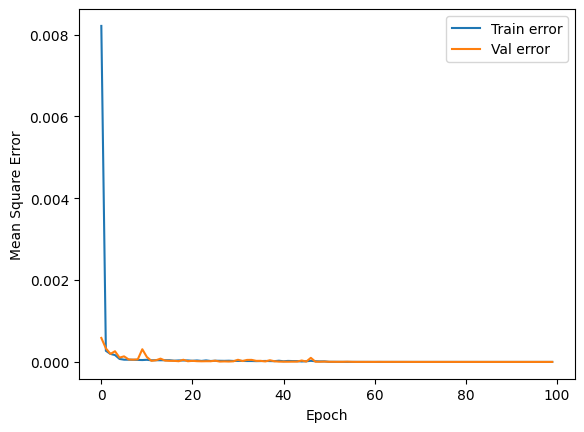

In [39]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [40]:
targets = pd.DataFrame(data=y_test, columns=INPUT_COLS)
predictions = pd.DataFrame(data=modelGRU.predict(X_test), columns=INPUT_COLS)

targets = denormalize(targets)
predictions = denormalize(predictions)

189/189 [==============================] - 2s 3ms/step


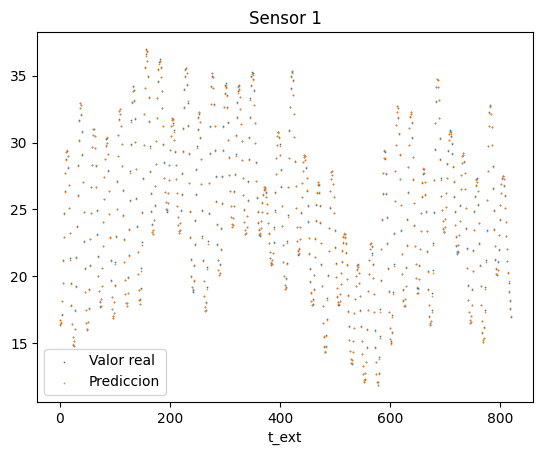

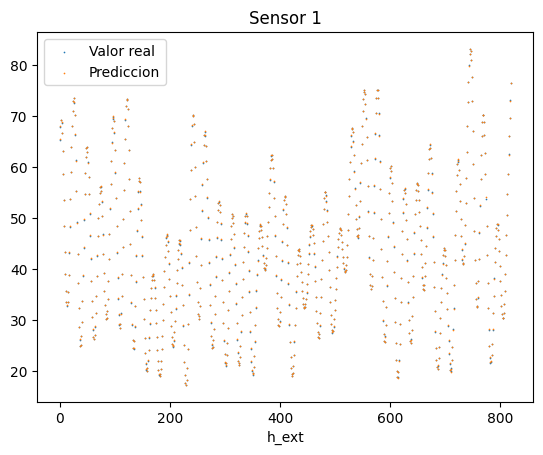

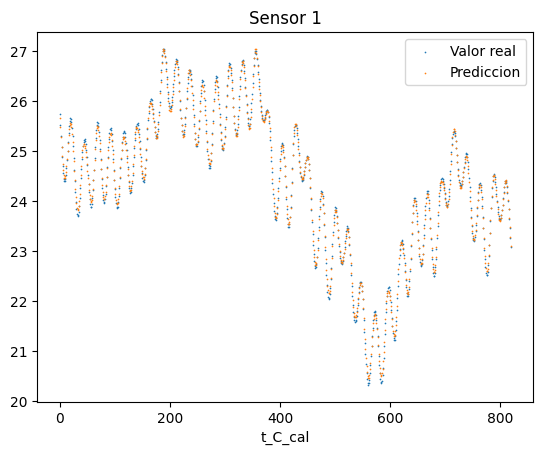

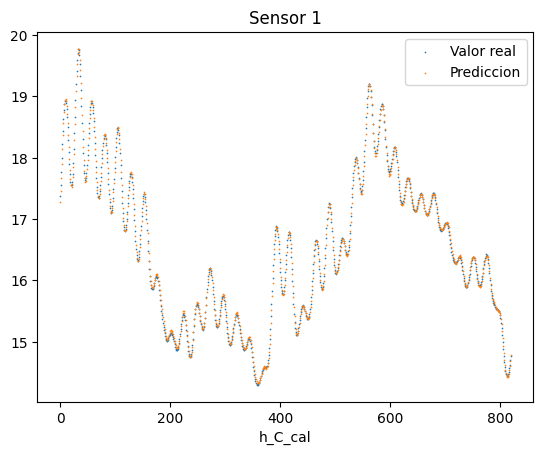

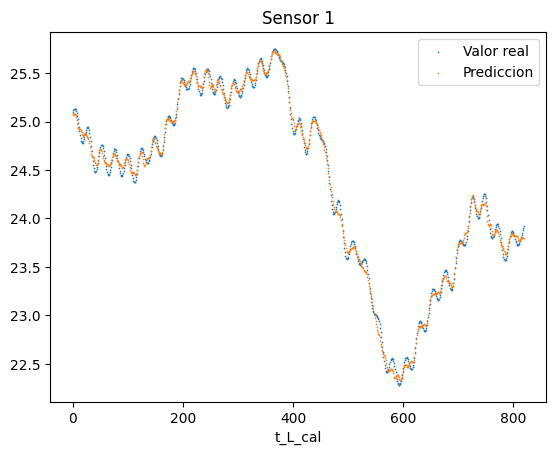

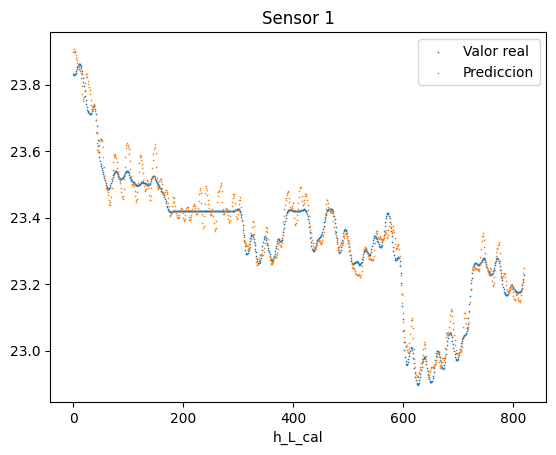

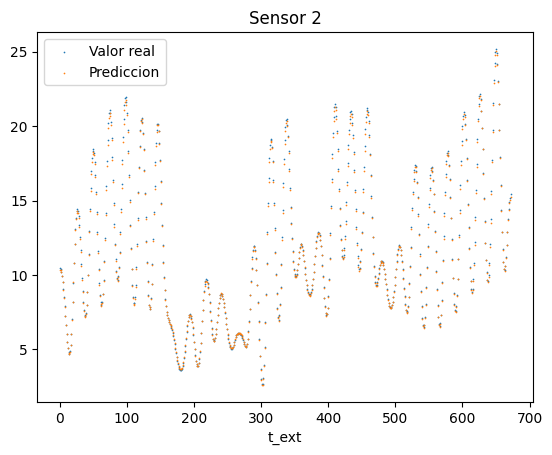

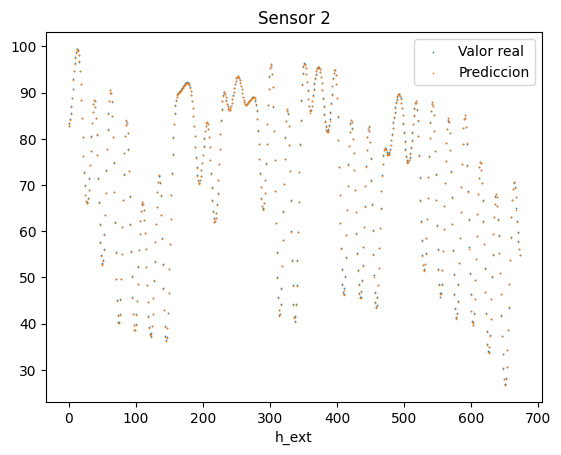

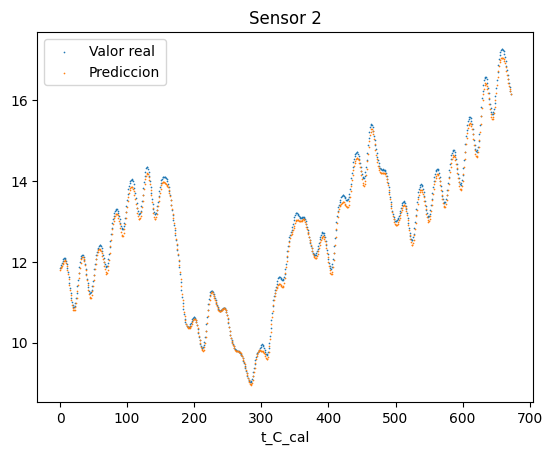

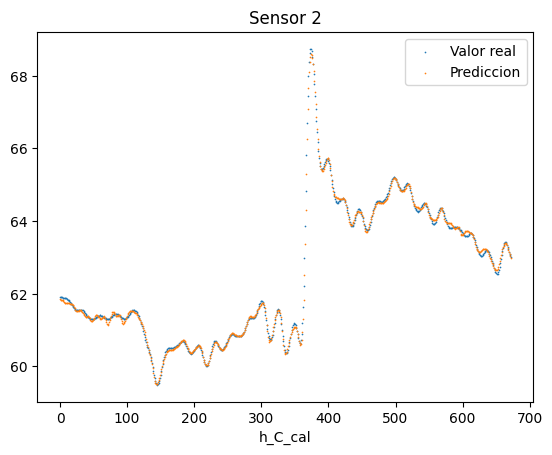

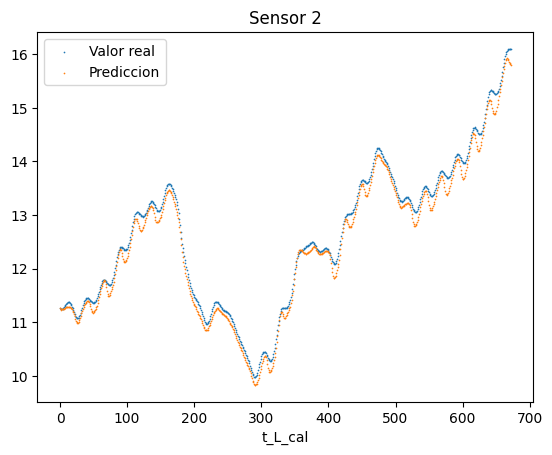

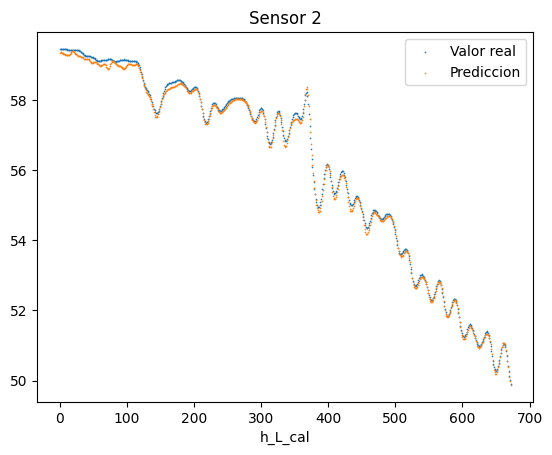

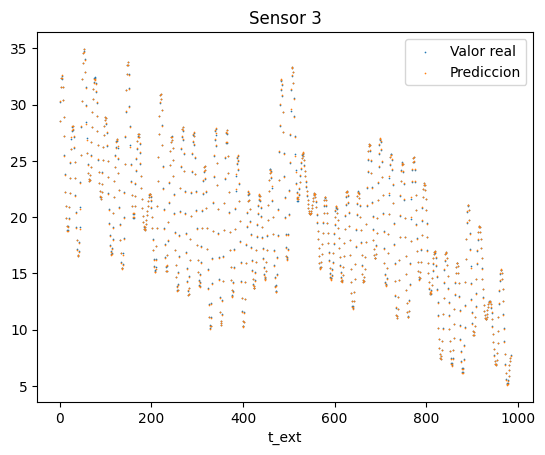

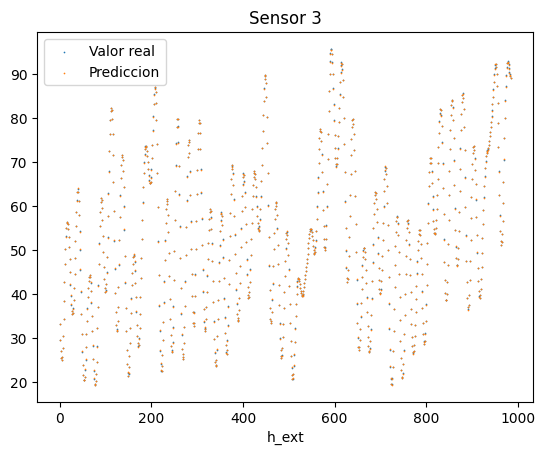

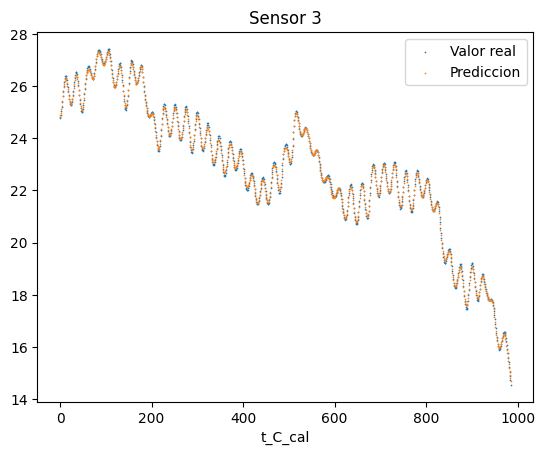

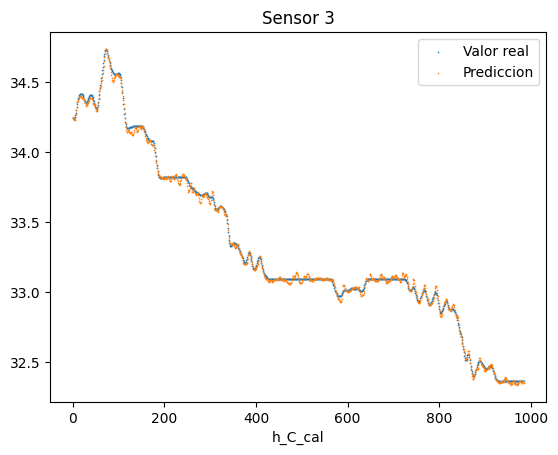

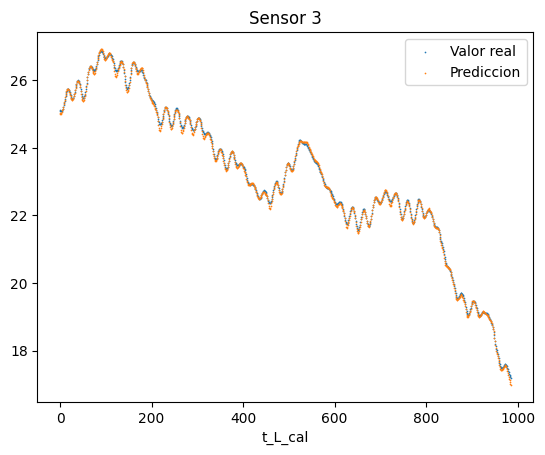

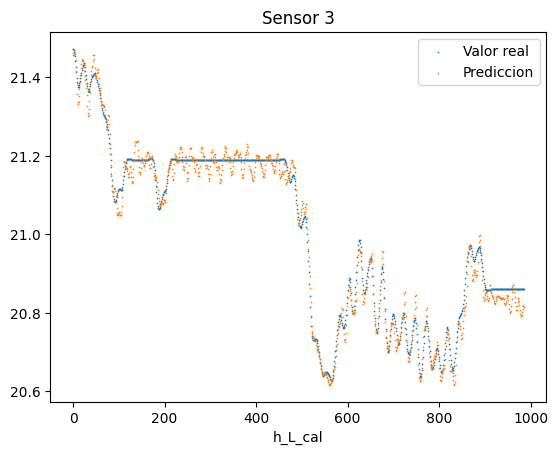

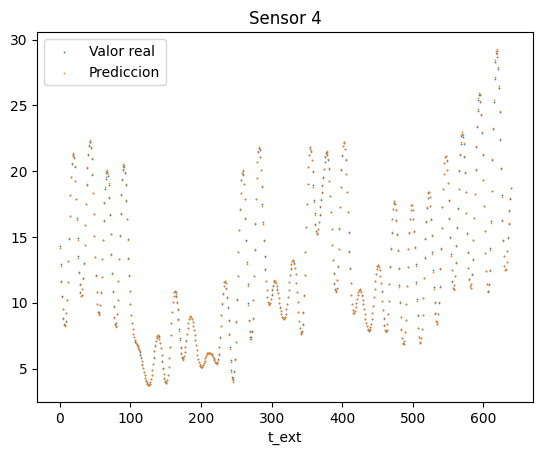

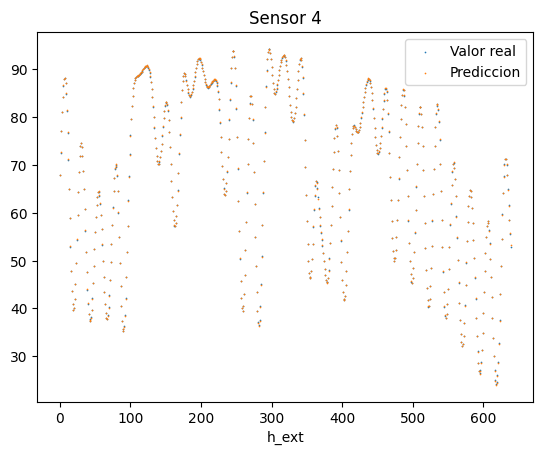

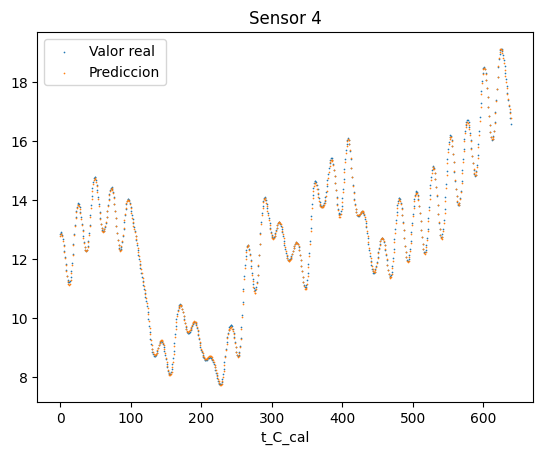

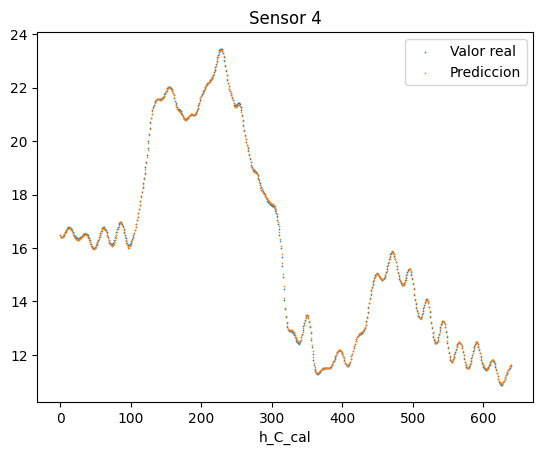

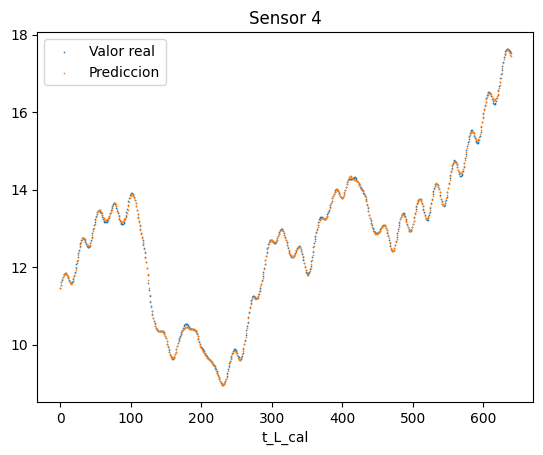

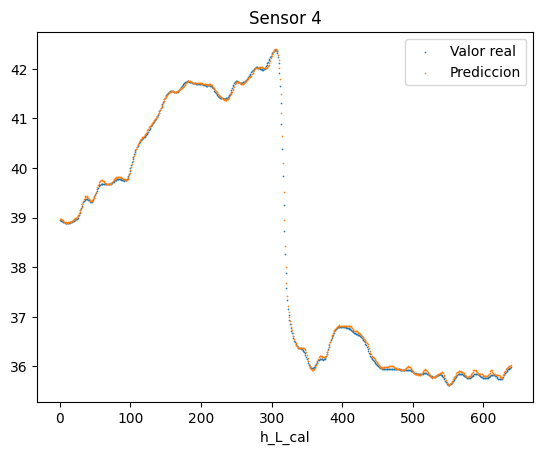

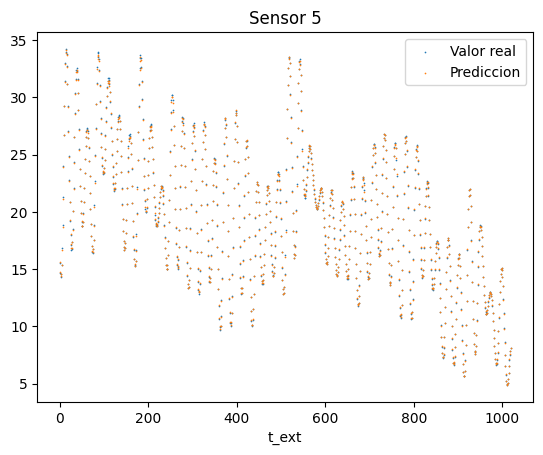

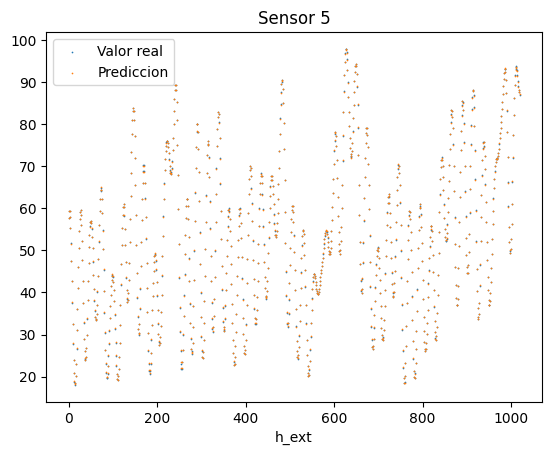

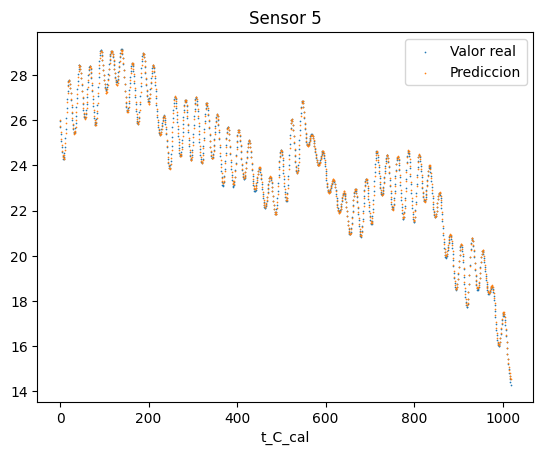

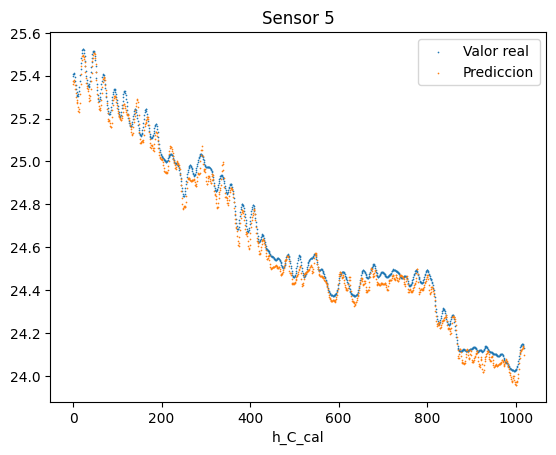

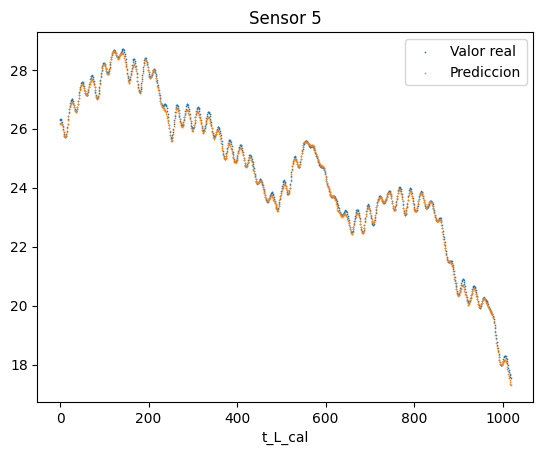

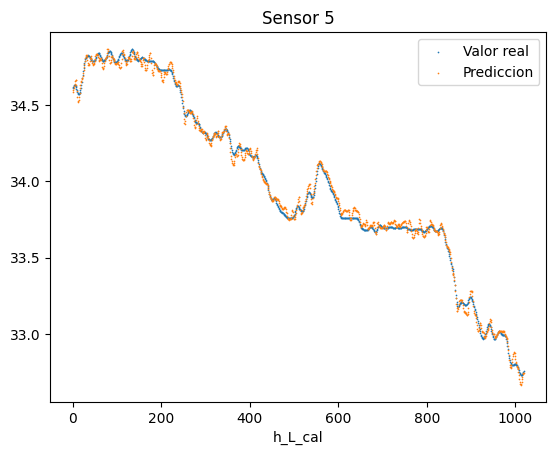

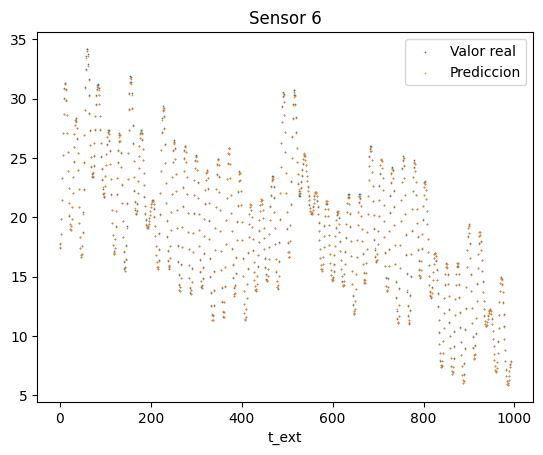

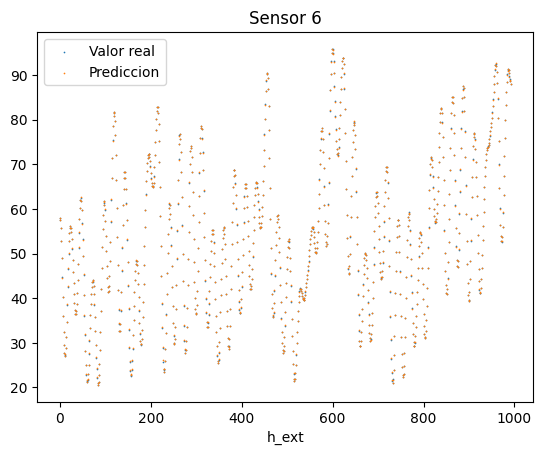

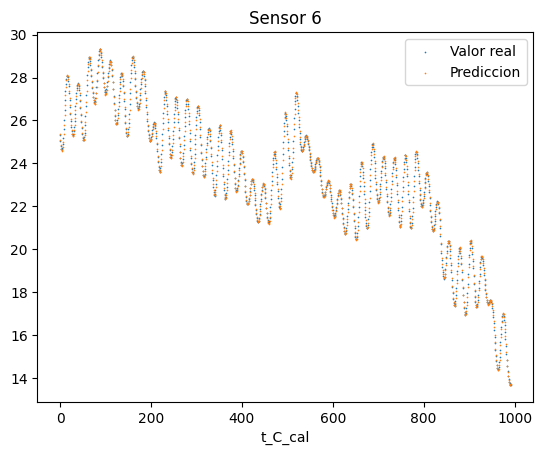

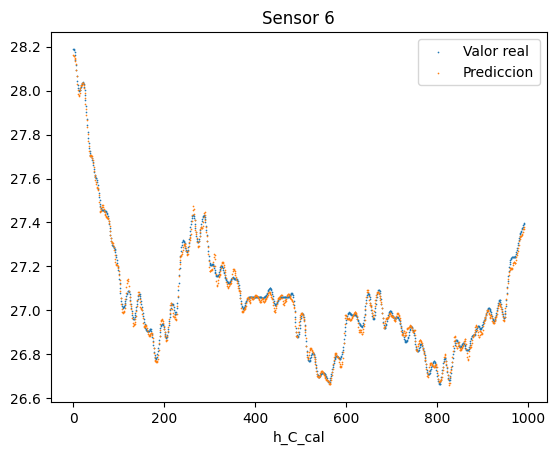

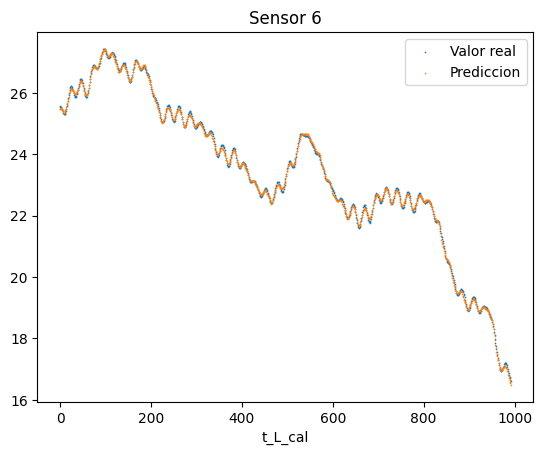

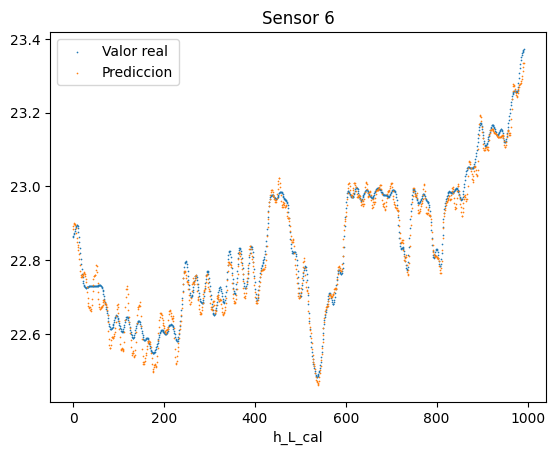

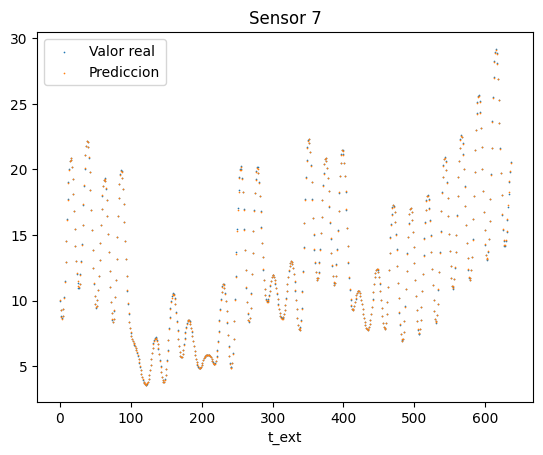

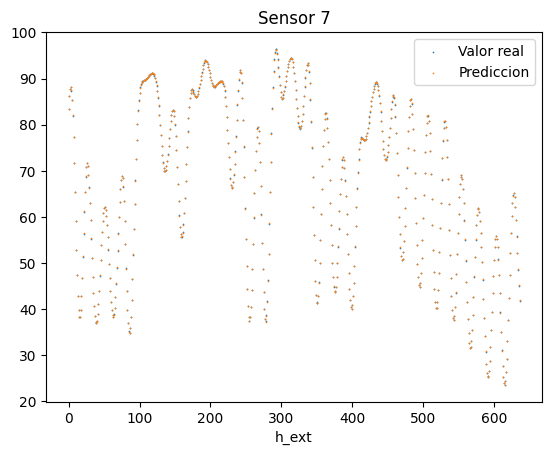

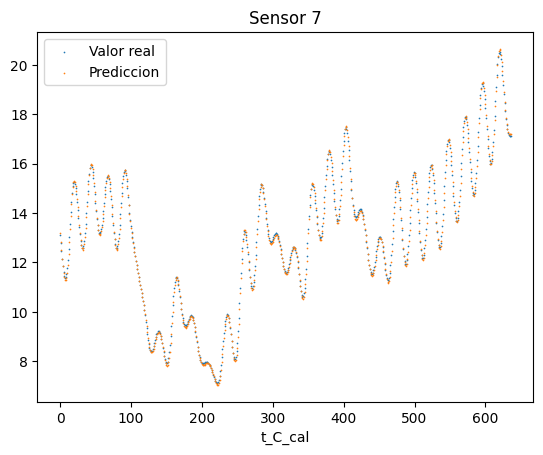

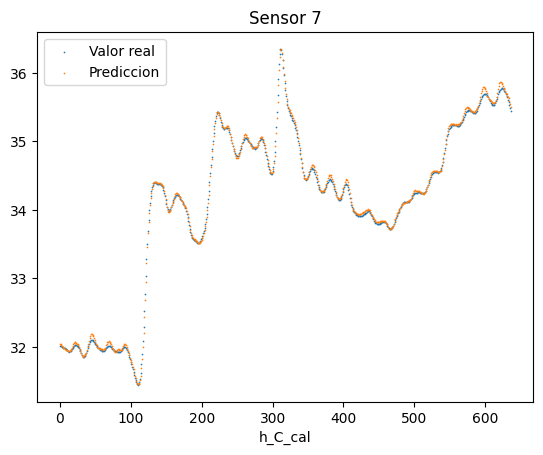

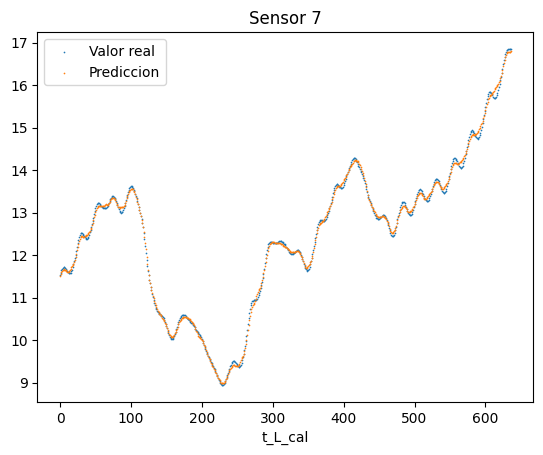

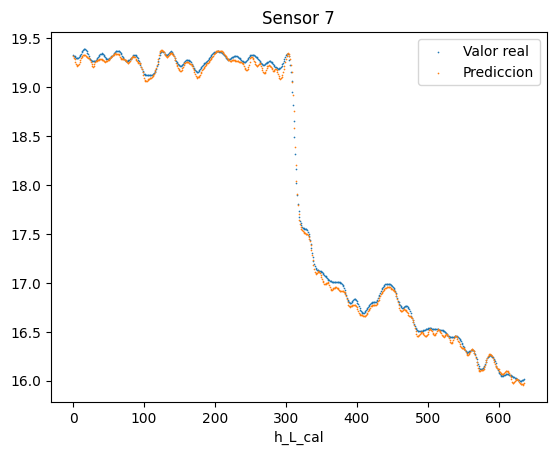

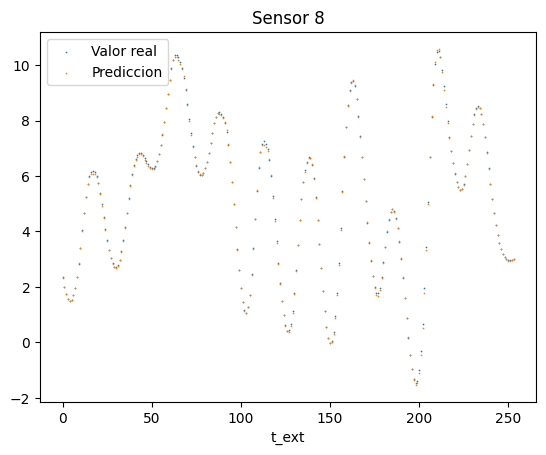

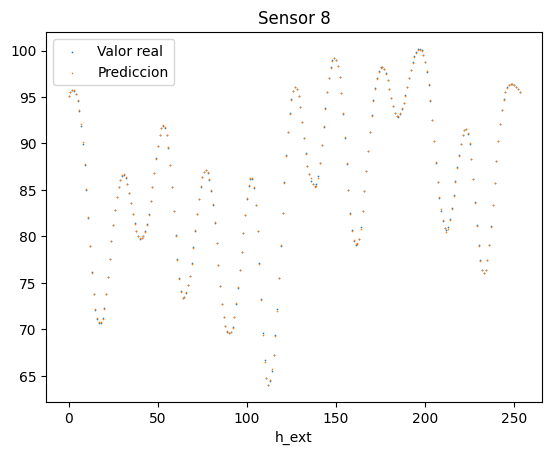

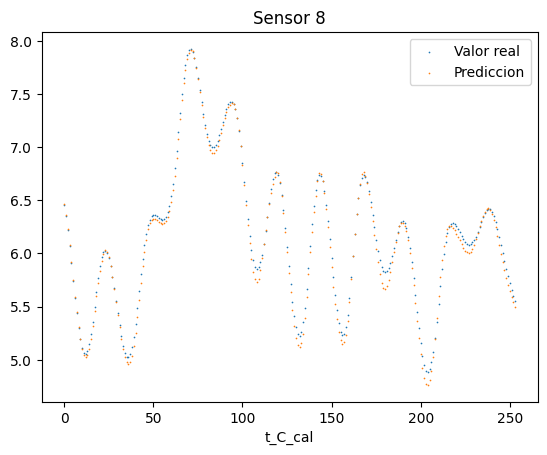

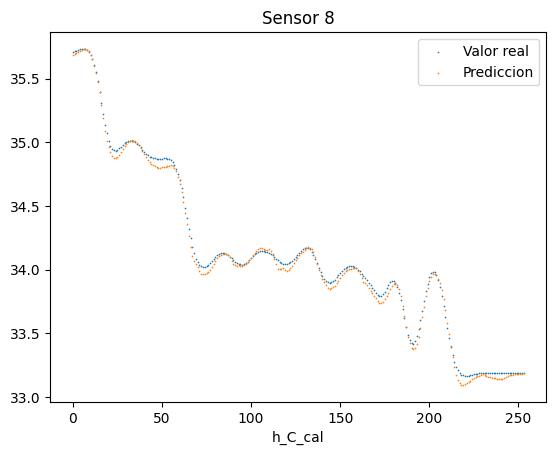

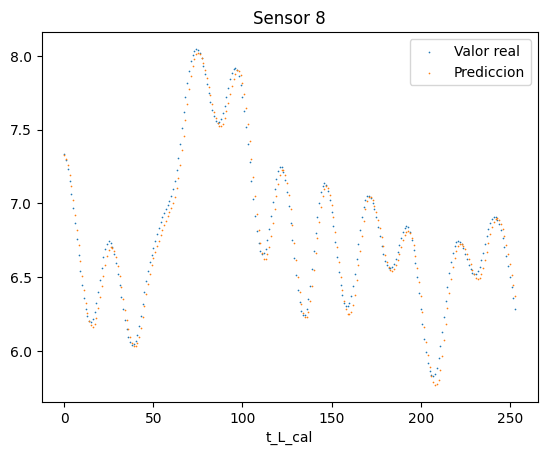

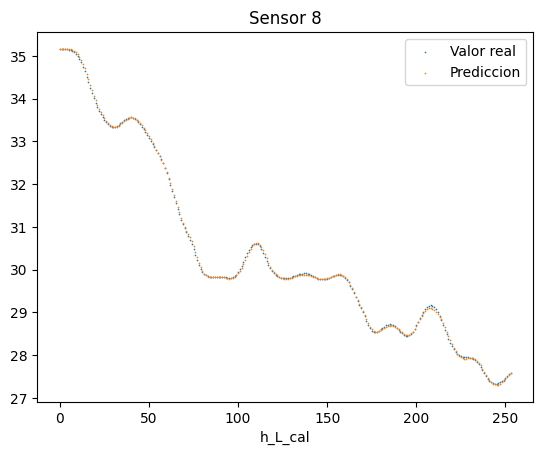

In [41]:

for sensor, (lim_inf, lim_sup) in enumerate(zip(data_limits, data_limits[1:]), 1):
    for col in INPUT_COLS:
        plt.figure(num="Sensor " + str(sensor))
        plt.title("Sensor " + str(sensor))
        plt.scatter(range(len(targets[col][lim_inf:lim_sup])), targets[col][lim_inf:lim_sup], linewidths=0.5, s=0.5)
        plt.scatter(range(len(predictions[col][lim_inf:lim_sup])), predictions[col][lim_inf:lim_sup], linewidths=0.5, s=0.5)
        plt.legend(["Valor real", "Prediccion"])
        plt.xlabel(col)
        plt.show()

In [42]:
for col in INPUT_COLS:
    print(col, max(abs(targets[col] - predictions[col])))

t_ext 0.3398717621673484
h_ext 0.32818633029253874
t_C_cal 0.315440250700334
h_C_cal 0.5224088008295524
t_L_cal 0.3954442324108953
h_L_cal 0.27453905787767496


# LSTM

In [43]:
inputs = layers.Input(shape=X_train.shape[1:])
modelLSTM = layers.LSTM(32, return_sequences=True)(inputs)
modelLSTM = layers.LSTM(16, return_sequences=True)(modelLSTM)
modelLSTM = layers.LSTM(8)(modelLSTM)
outputs = layers.Dense(6)(modelLSTM)

modelLSTM = kr.Model(inputs=inputs, outputs=outputs)
# ch_callback = kr.callbacks.ModelCheckpoint(filepath="./tmp/checkpoint", monitor="val_loss", save_best_only=True, mode="min", verbose=)
modelLSTM.compile(loss="mse", optimizer=get_optimizer())
modelLSTM.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 6, 6)]            0         
                                                                 
 lstm_3 (LSTM)               (None, 6, 32)             4992      
                                                                 
 lstm_4 (LSTM)               (None, 6, 16)             3136      
                                                                 
 lstm_5 (LSTM)               (None, 8)                 800       
                                                                 
 dense_7 (Dense)             (None, 6)                 54        
                                                                 
Total params: 8,982
Trainable params: 8,982
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Entrenamiento de la RNA
history = modelLSTM.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[sc_callback], workers=10)

Epoch 1/100
177/177 [==============================] - 10s 26ms/step - loss: 0.0195 - val_loss: 0.0042 - lr: 0.0100
Epoch 2/100
177/177 [==============================] - 3s 18ms/step - loss: 0.0024 - val_loss: 9.5263e-04 - lr: 0.0100
Epoch 3/100
177/177 [==============================] - 3s 16ms/step - loss: 3.5246e-04 - val_loss: 4.2272e-04 - lr: 0.0100
Epoch 4/100
177/177 [==============================] - 3s 17ms/step - loss: 2.0021e-04 - val_loss: 2.8184e-04 - lr: 0.0100
Epoch 5/100
177/177 [==============================] - 4s 23ms/step - loss: 1.7306e-04 - val_loss: 1.9145e-04 - lr: 0.0100
Epoch 6/100
177/177 [==============================] - 3s 19ms/step - loss: 1.3656e-04 - val_loss: 9.6662e-05 - lr: 0.0100
Epoch 7/100
177/177 [==============================] - 3s 18ms/step - loss: 8.6558e-05 - val_loss: 9.9482e-05 - lr: 0.0100
Epoch 8/100
177/177 [==============================] - 3s 17ms/step - loss: 7.4439e-05 - val_loss: 1.1746e-04 - lr: 0.0100
Epoch 9/100
177/177 [======

In [45]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

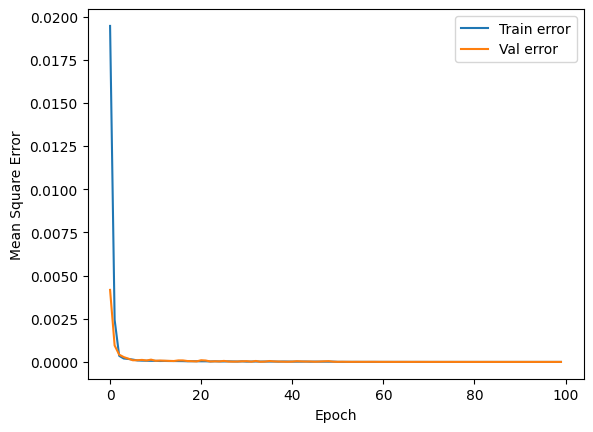

In [46]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [47]:
targets = pd.DataFrame(data=y_test, columns=INPUT_COLS)
predictions = pd.DataFrame(data=modelLSTM.predict(X_test), columns=INPUT_COLS)

targets = denormalize(targets)
predictions = denormalize(predictions)

189/189 [==============================] - 2s 4ms/step


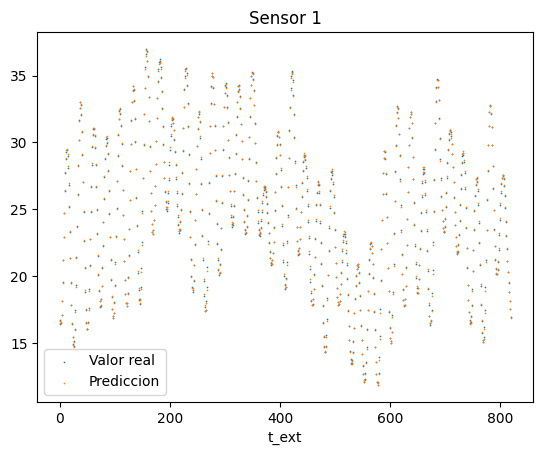

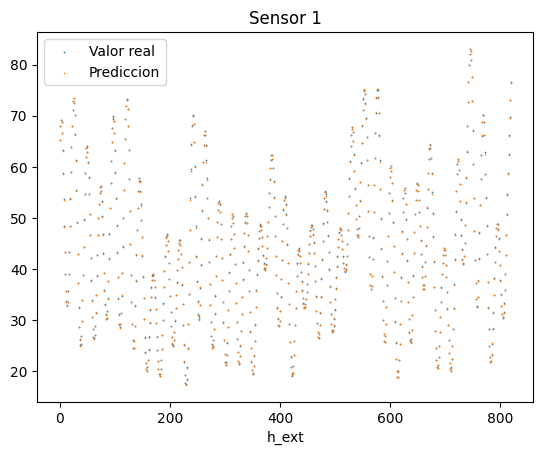

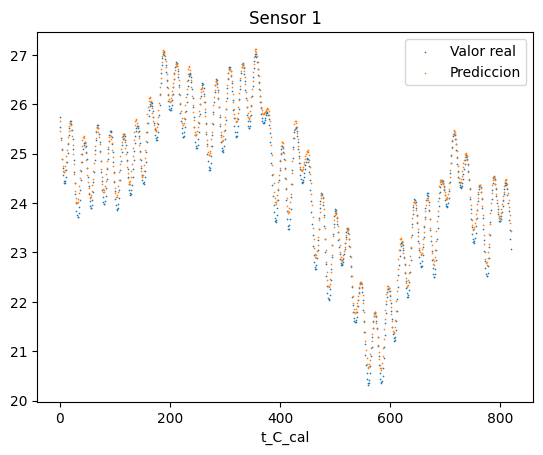

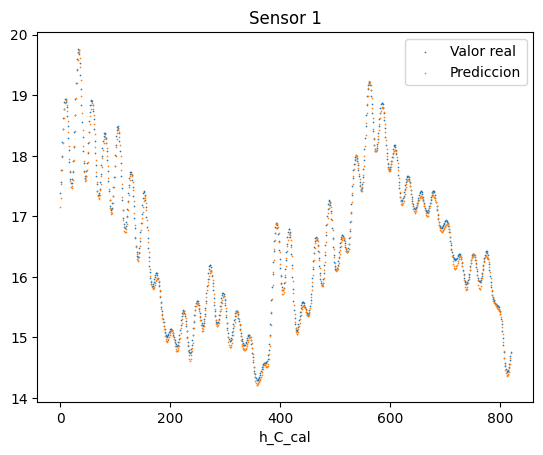

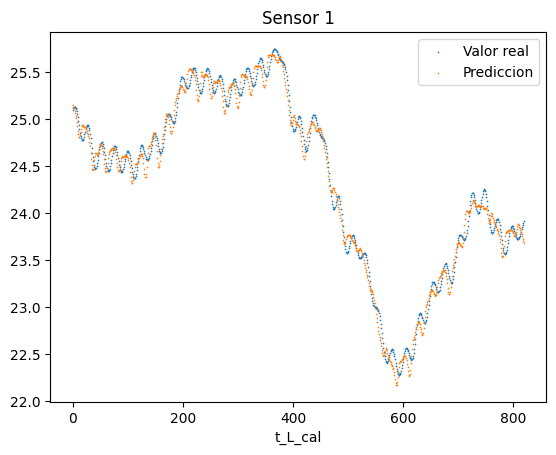

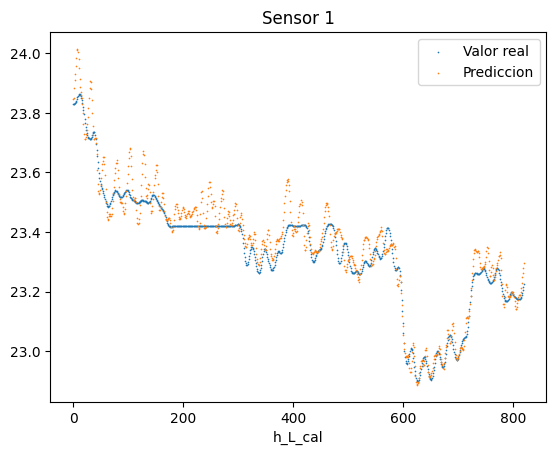

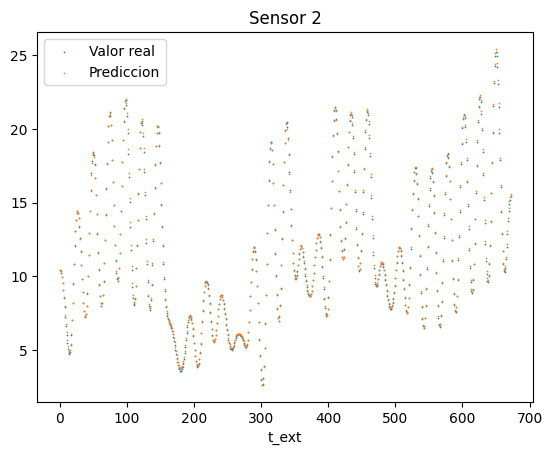

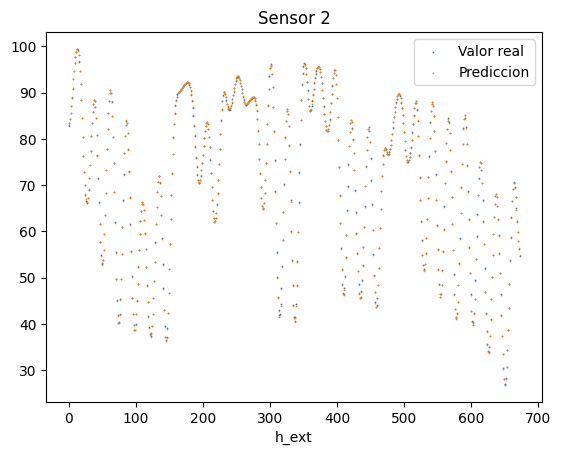

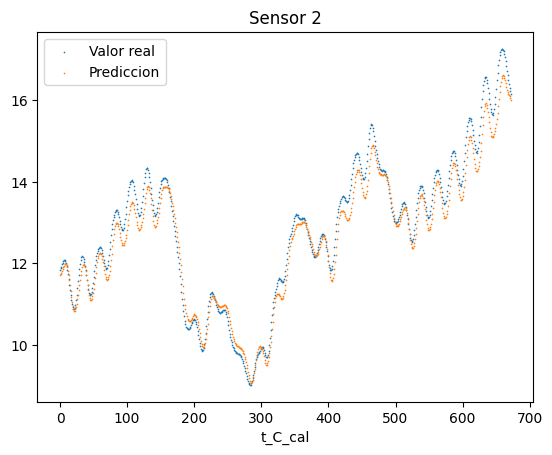

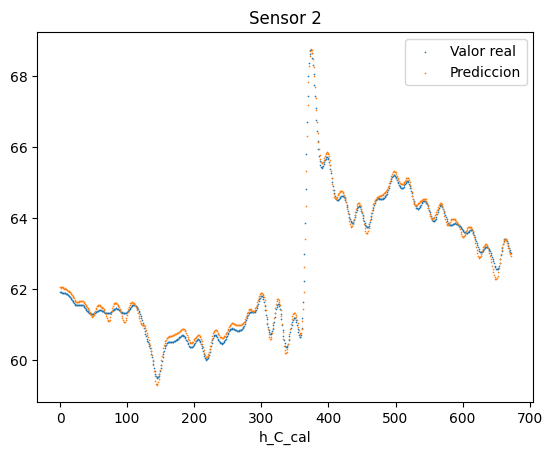

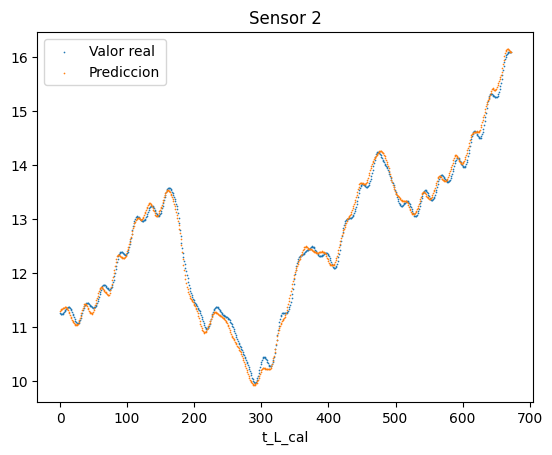

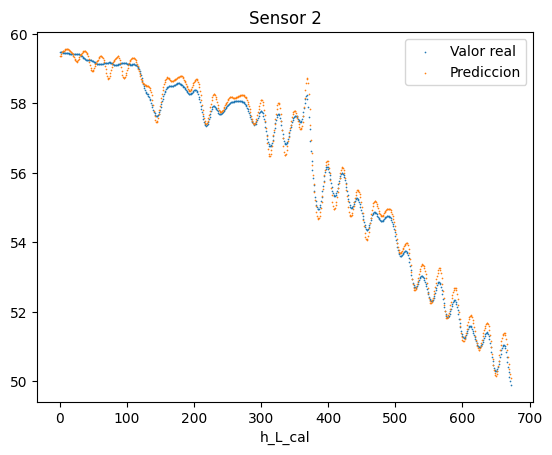

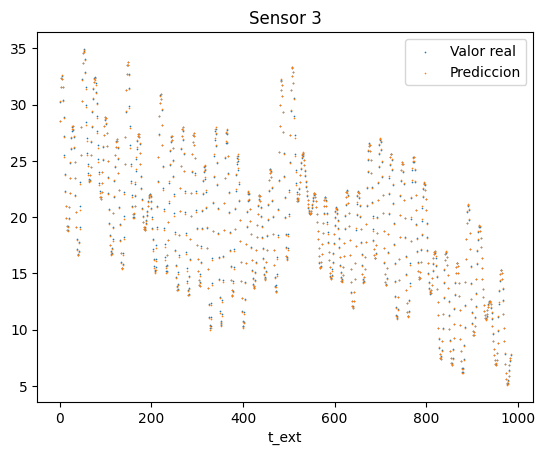

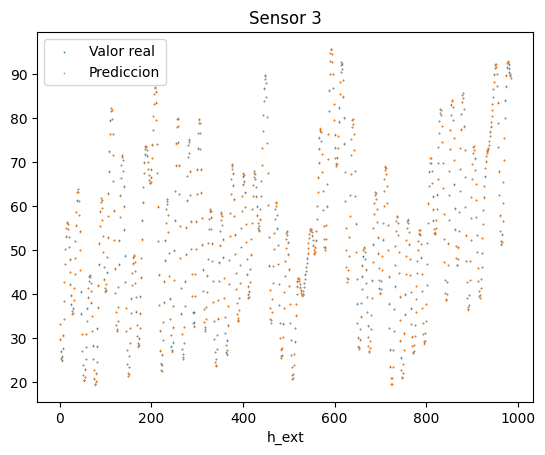

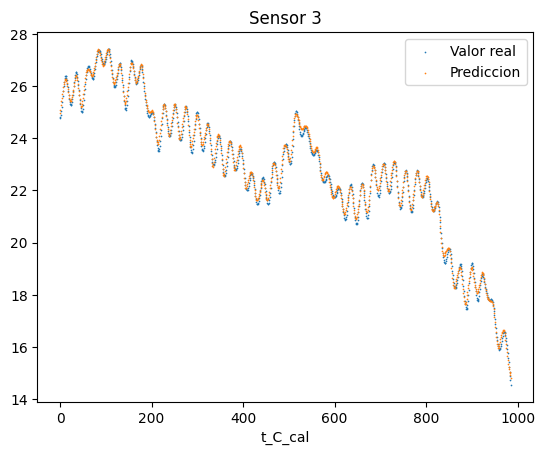

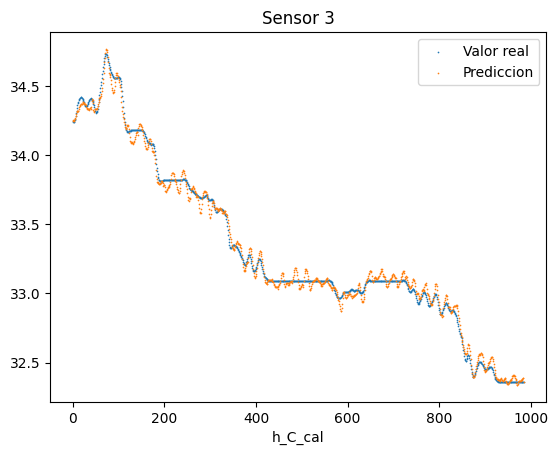

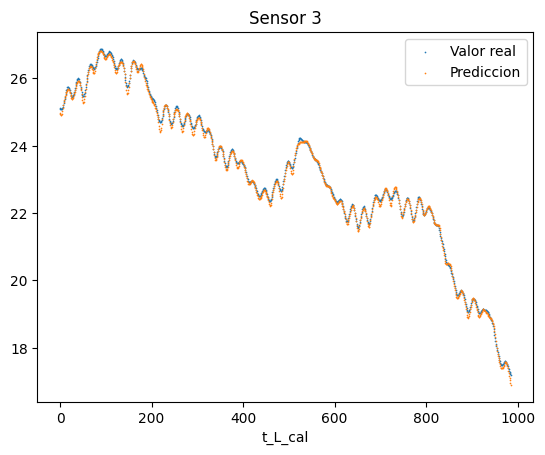

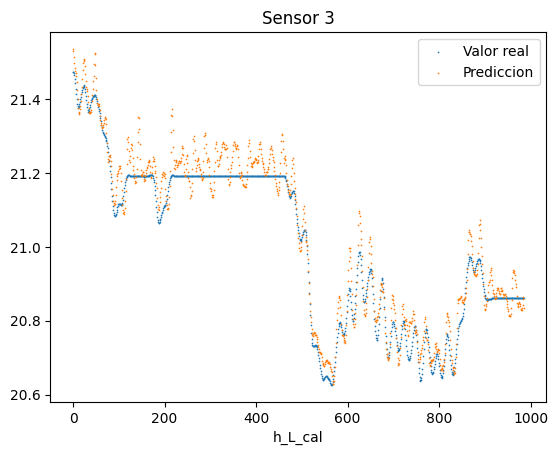

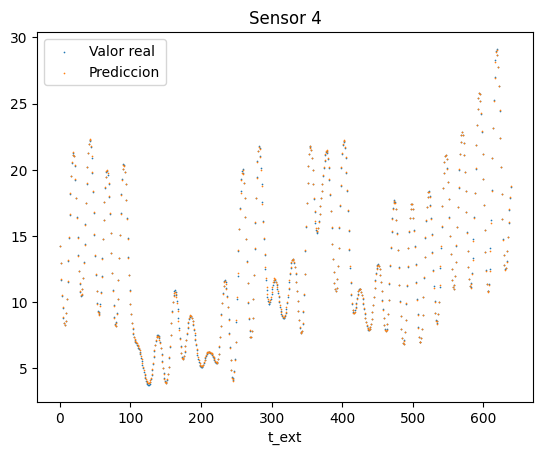

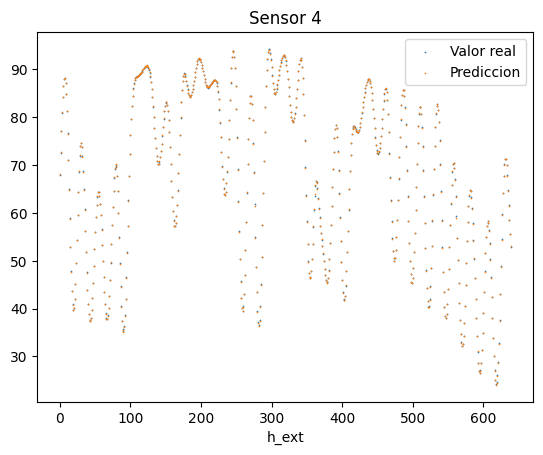

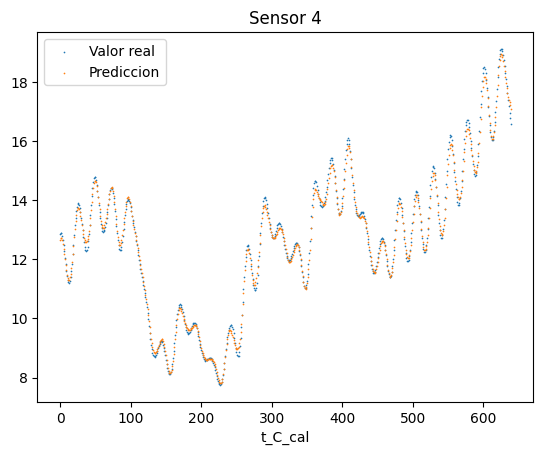

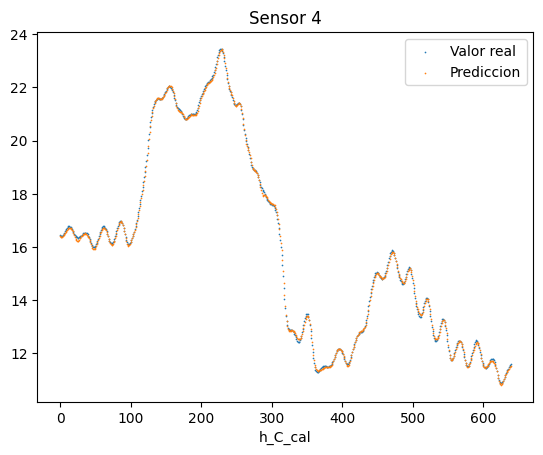

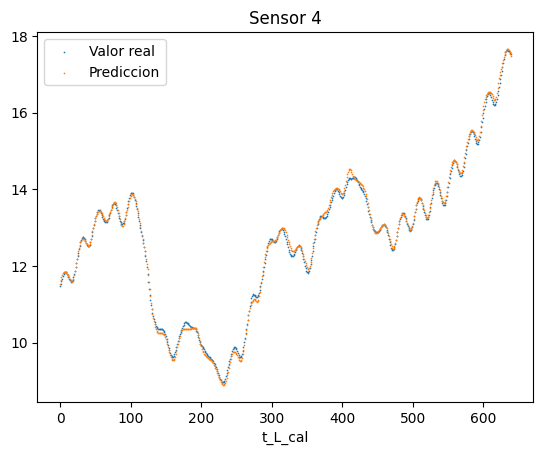

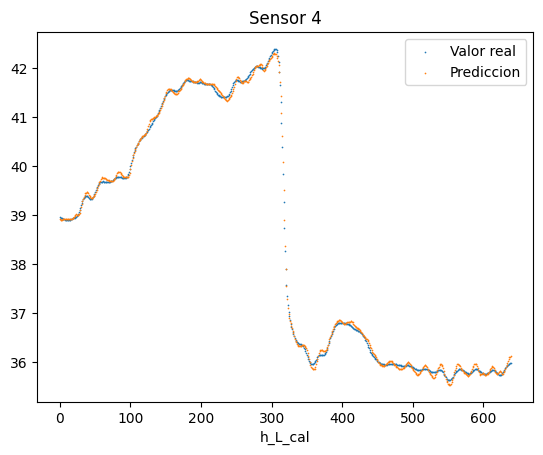

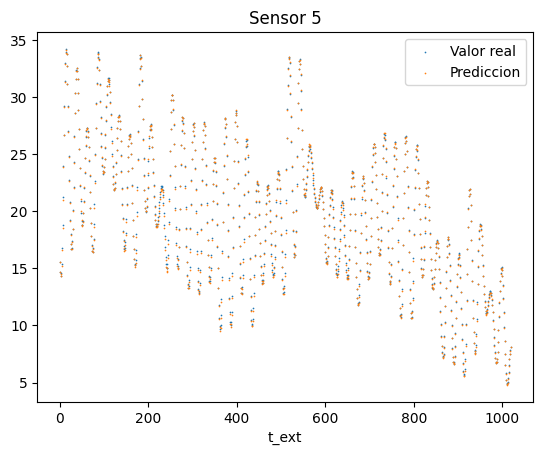

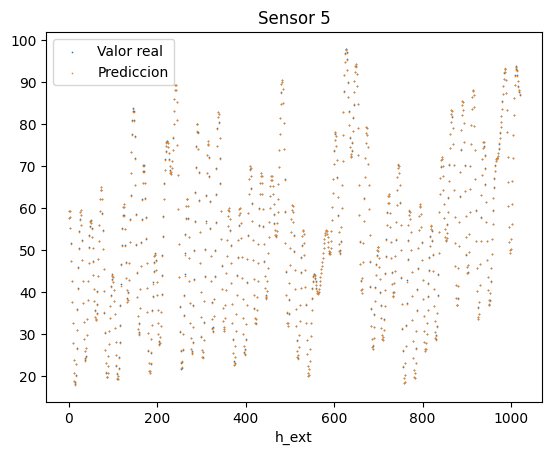

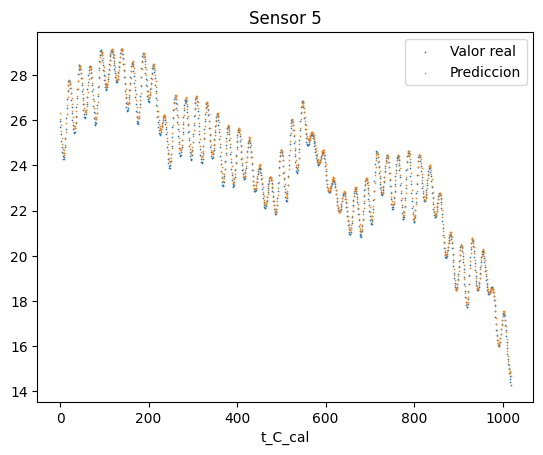

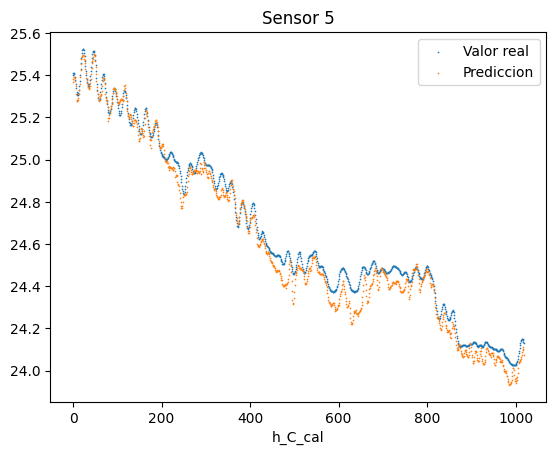

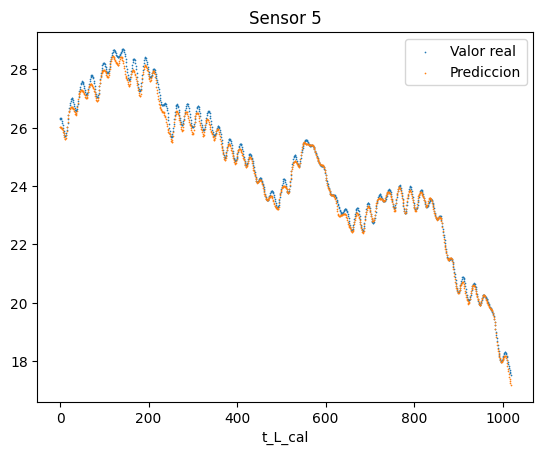

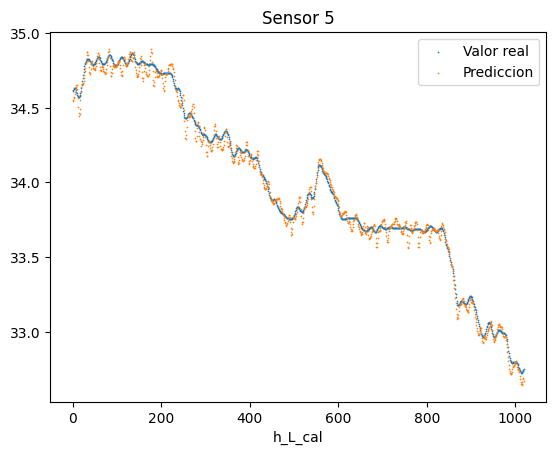

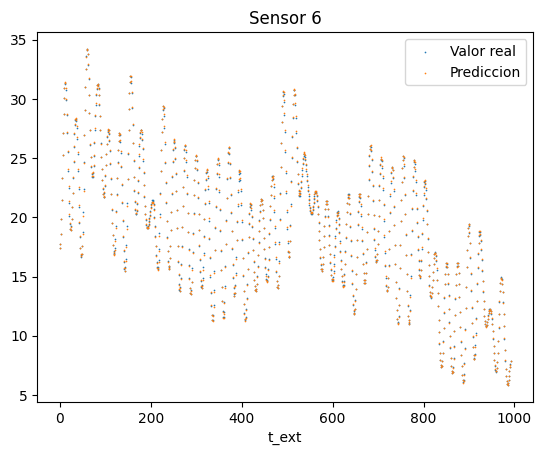

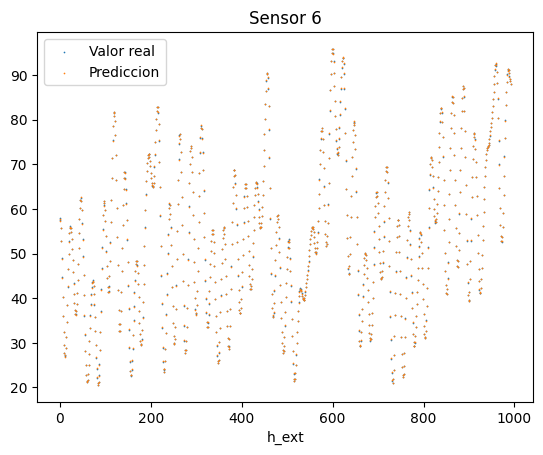

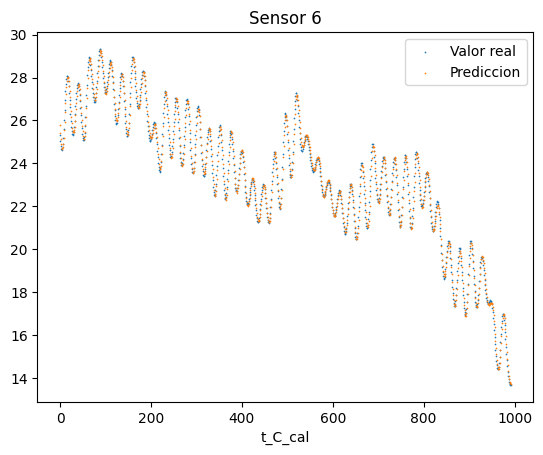

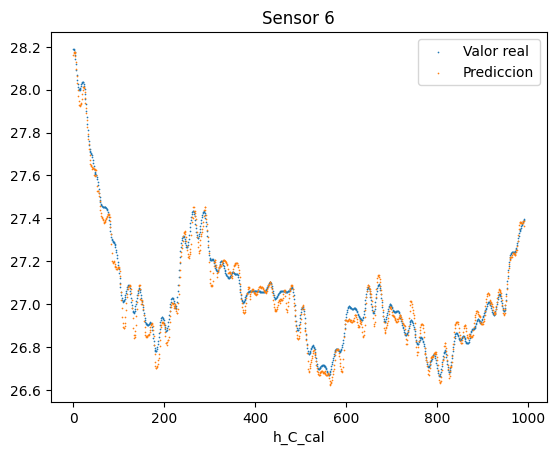

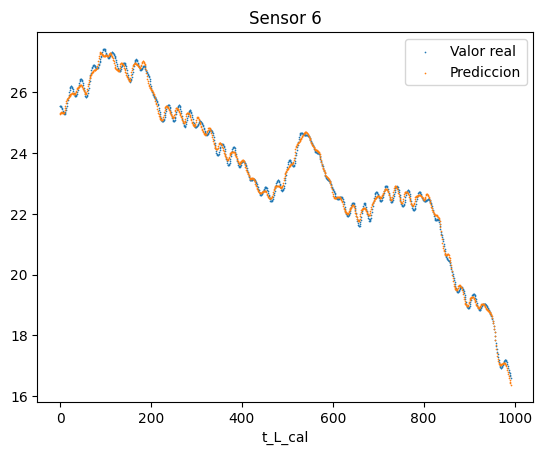

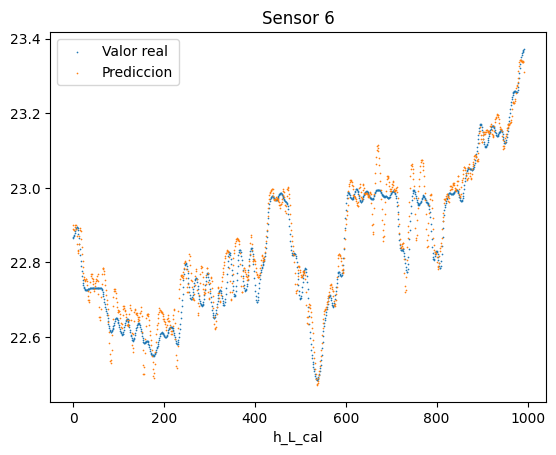

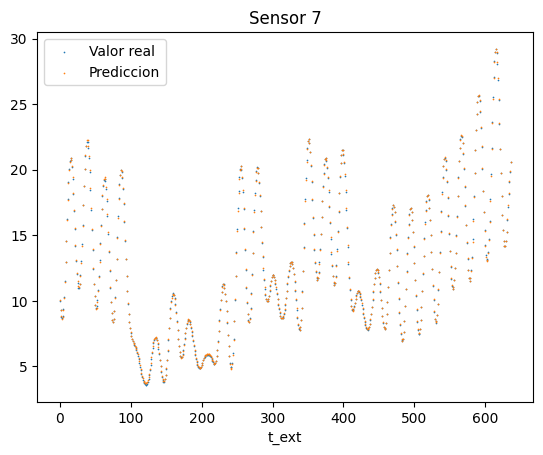

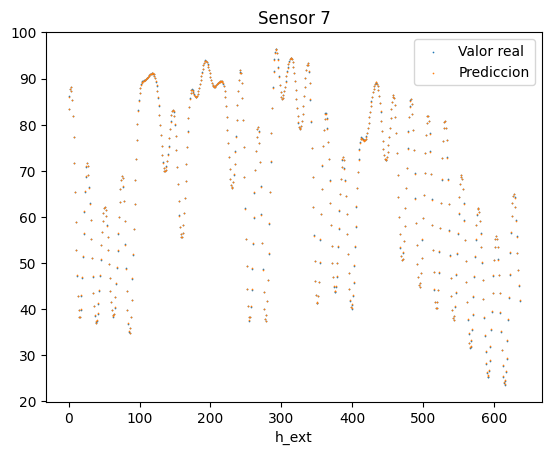

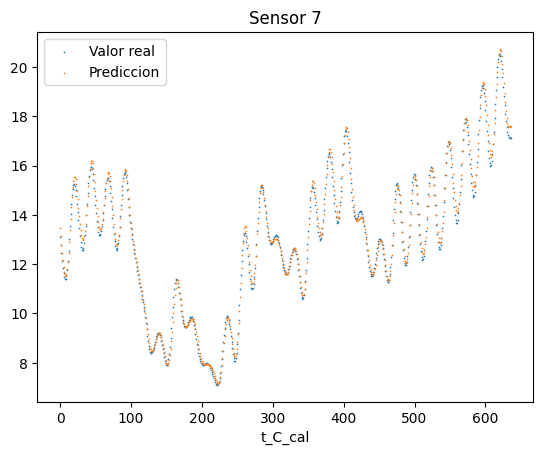

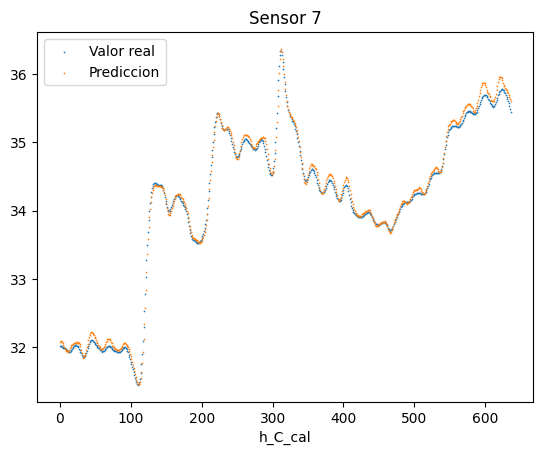

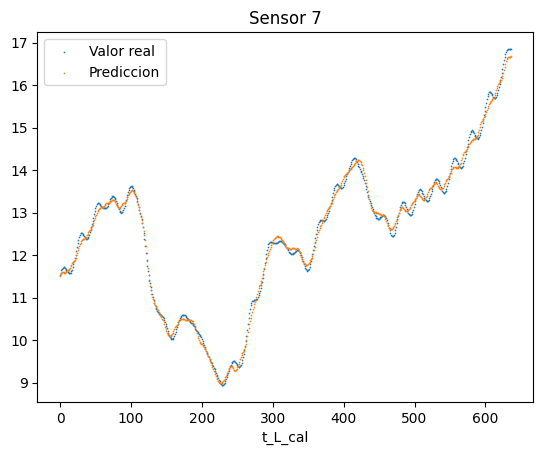

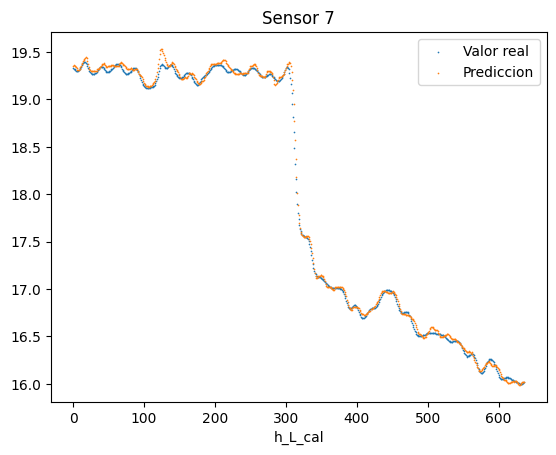

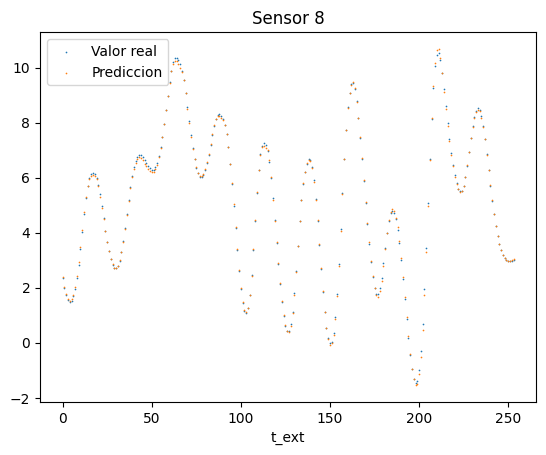

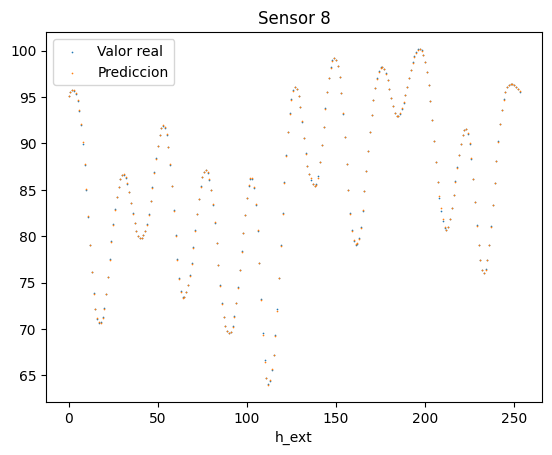

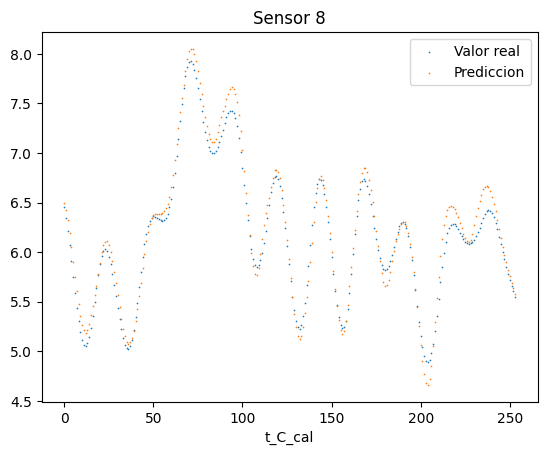

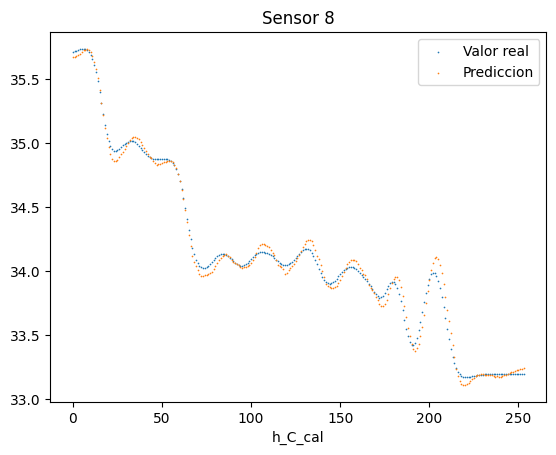

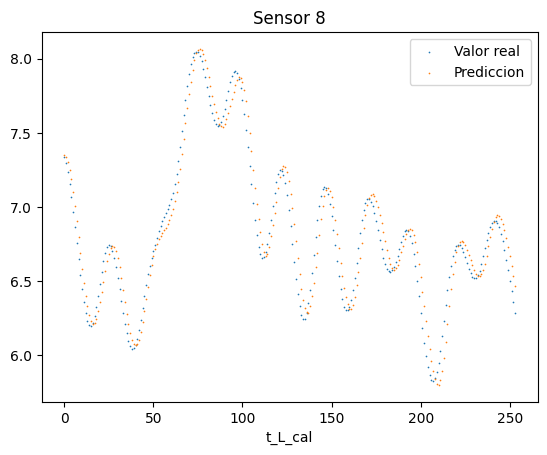

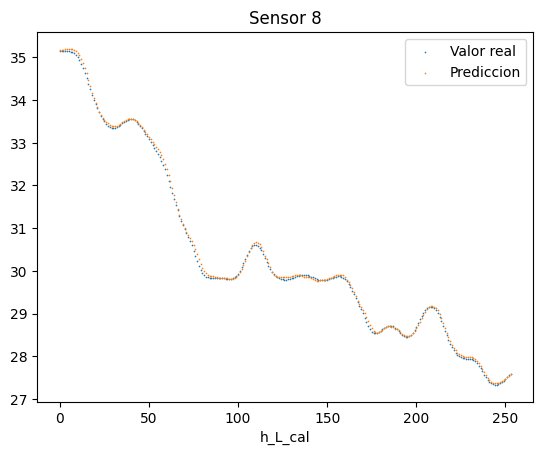

In [48]:
for sensor, (lim_inf, lim_sup) in enumerate(zip(data_limits, data_limits[1:]), 1):
    for col in INPUT_COLS:
        plt.figure(num="Sensor " + str(sensor))
        plt.title("Sensor " + str(sensor))
        plt.scatter(range(len(targets[col][lim_inf:lim_sup])), targets[col][lim_inf:lim_sup], linewidths=0.5, s=0.5)
        plt.scatter(range(len(predictions[col][lim_inf:lim_sup])), predictions[col][lim_inf:lim_sup], linewidths=0.5, s=0.5)
        plt.legend(["Valor real", "Prediccion"])
        plt.xlabel(col)
        plt.show()

In [49]:
for col in INPUT_COLS:
    print(col, max(abs(targets[col] - predictions[col])))

t_ext 0.33633027244350444
h_ext 0.3889038559787963
t_C_cal 0.9915829077222327
h_C_cal 0.4800275142084587
t_L_cal 0.6004100788259024
h_L_cal 0.6759514858865998


# MLP

In [50]:
# Modificamos los tensores de entrada transformandoles en vectores de entrada, para que pueden ser empleados por la MLP
X_train_mlp = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_val_mlp = X_val.reshape((X_val.shape[0], X_val.shape[1] * X_val.shape[2]))

inputs = layers.Input(shape=X_train_mlp.shape[1:])
modelMLP = layers.Dense(32)(inputs)
modelMLP = layers.Dense(16)(modelMLP)
modelMLP = layers.Dense(8)(modelMLP)
outputs = layers.Dense(6)(modelMLP)

modelMLP = kr.Model(inputs=inputs, outputs=outputs)
modelMLP.compile(loss="mse", optimizer=get_optimizer())
modelMLP.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense_8 (Dense)             (None, 32)                1184      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 6)                 54        
                                                                 
Total params: 1,902
Trainable params: 1,902
Non-trainable params: 0
_________________________________________________________________


In [51]:
history = modelMLP.fit(x=X_train_mlp, y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val_mlp, y_val), callbacks=[sc_callback], workers=10)

Epoch 1/100
177/177 [==============================] - 2s 4ms/step - loss: 0.0154 - val_loss: 5.7260e-04 - lr: 0.0100
Epoch 2/100
177/177 [==============================] - 0s 2ms/step - loss: 3.1823e-04 - val_loss: 4.5633e-04 - lr: 0.0100
Epoch 3/100
177/177 [==============================] - 0s 2ms/step - loss: 2.4747e-04 - val_loss: 2.6079e-04 - lr: 0.0100
Epoch 4/100
177/177 [==============================] - 0s 2ms/step - loss: 2.0614e-04 - val_loss: 1.9016e-04 - lr: 0.0100
Epoch 5/100
177/177 [==============================] - 1s 3ms/step - loss: 1.7515e-04 - val_loss: 1.1746e-04 - lr: 0.0100
Epoch 6/100
177/177 [==============================] - 0s 3ms/step - loss: 8.4049e-05 - val_loss: 9.8426e-05 - lr: 0.0100
Epoch 7/100
177/177 [==============================] - 0s 2ms/step - loss: 7.6259e-05 - val_loss: 8.8791e-05 - lr: 0.0100
Epoch 8/100
177/177 [==============================] - 0s 2ms/step - loss: 7.4025e-05 - val_loss: 6.4944e-05 - lr: 0.0100
Epoch 9/100
177/177 [=======

In [52]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

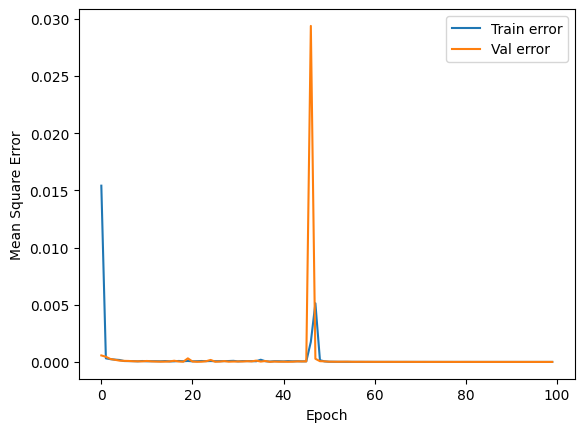

In [53]:
plt.figure()
plt.plot(hist['epoch'], hist['loss'], label='Train error')
plt.plot(hist['epoch'], hist['val_loss'], label='Val error')
plt.xlabel("Epoch")
plt.ylabel("Mean Square Error")
plt.legend()

plt.legend()

In [54]:
X_test_mlp = X_test.reshape((X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

targets = pd.DataFrame(data=y_test, columns=INPUT_COLS)
predictions = pd.DataFrame(data=modelMLP.predict(X_test_mlp), columns=INPUT_COLS)

targets = denormalize(targets)
predictions = denormalize(predictions)

189/189 [==============================] - 0s 1ms/step


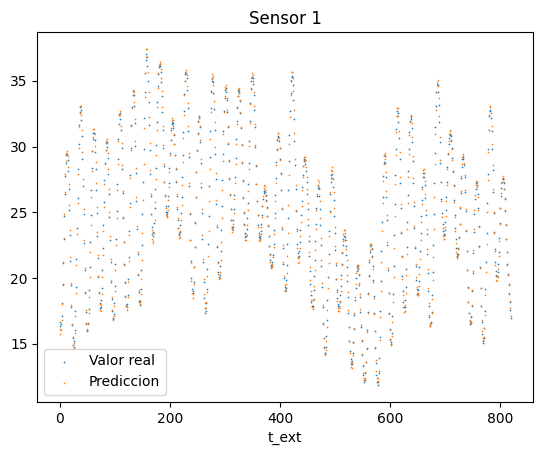

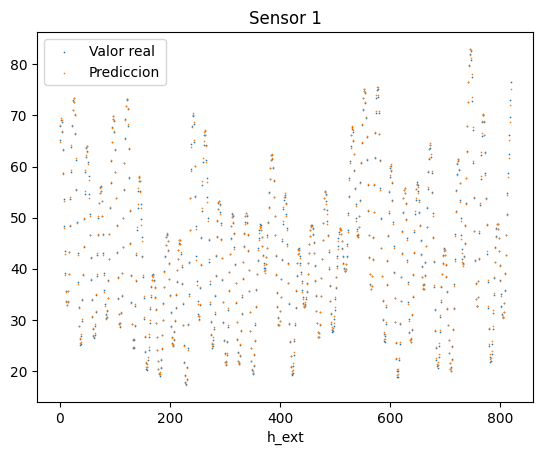

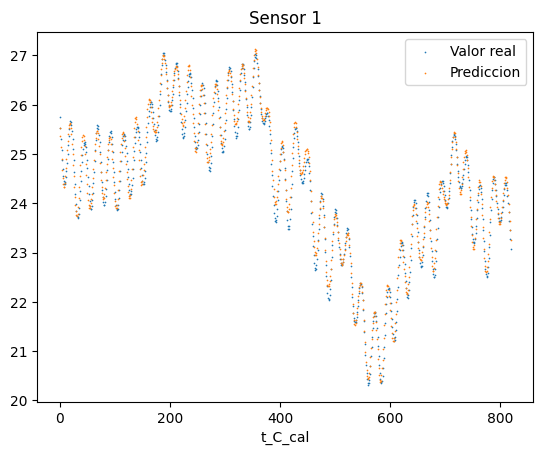

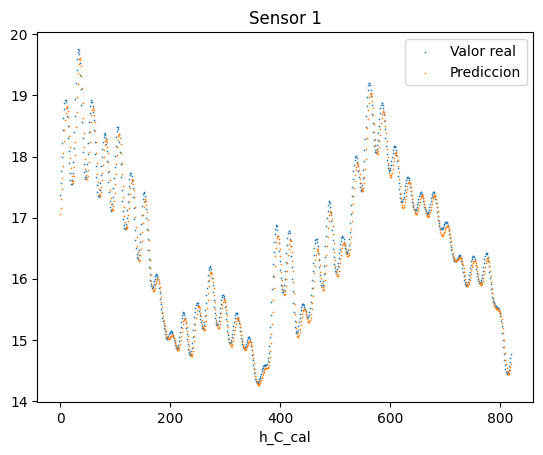

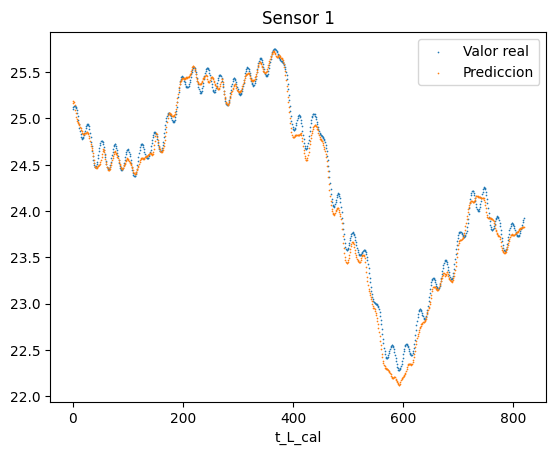

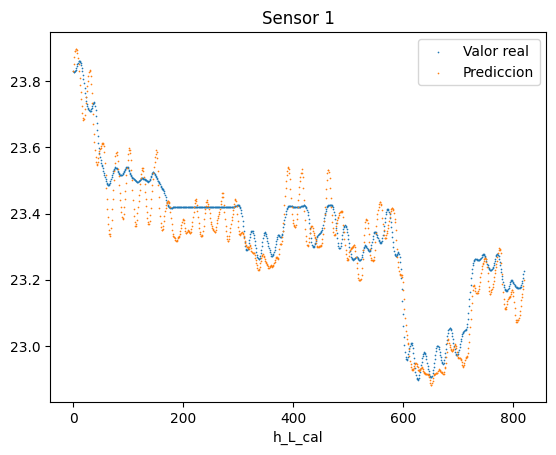

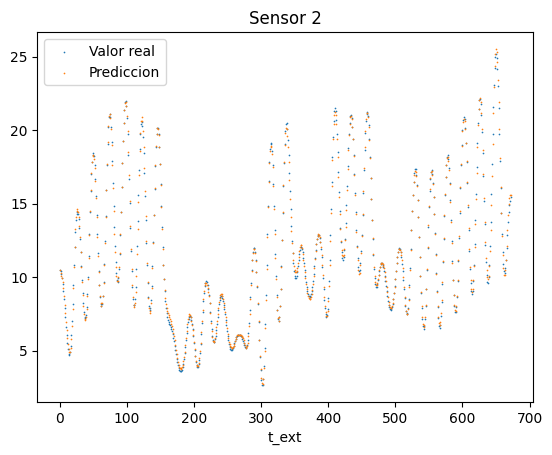

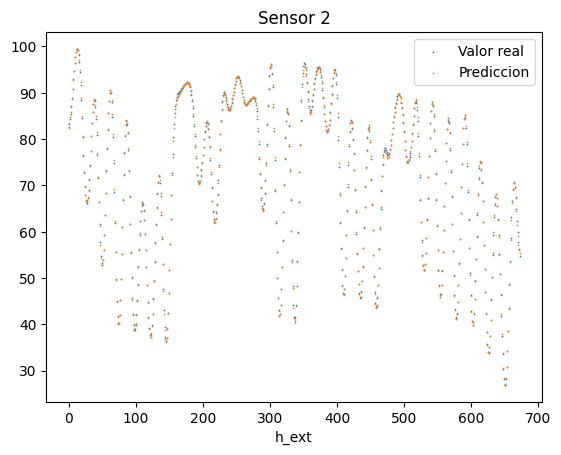

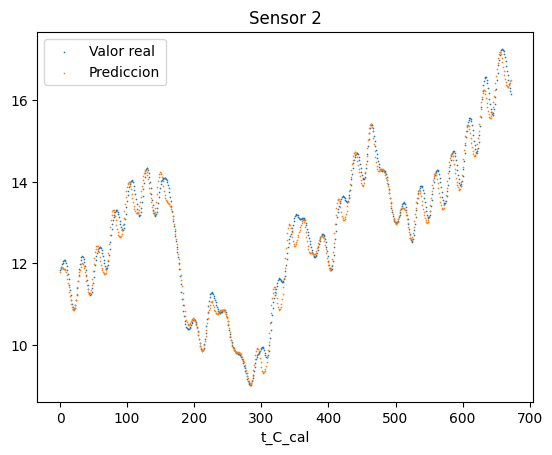

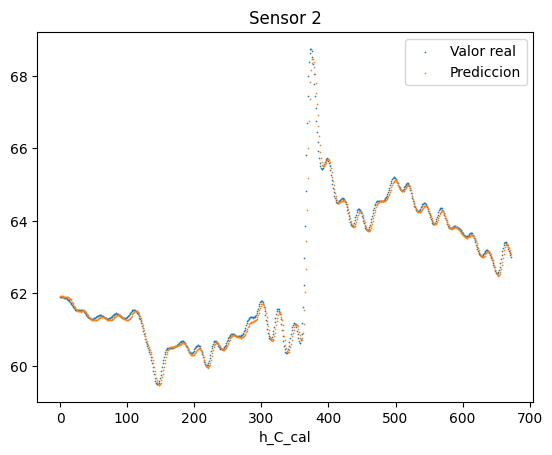

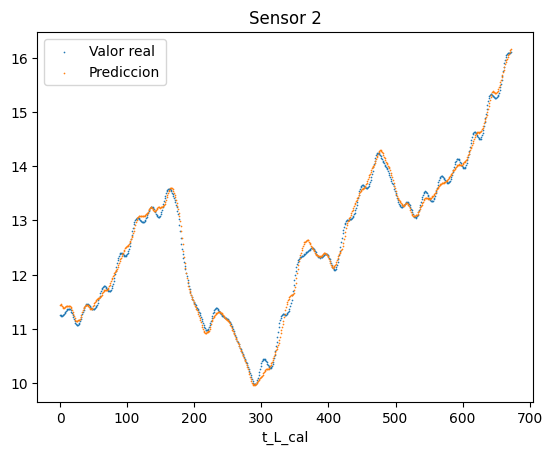

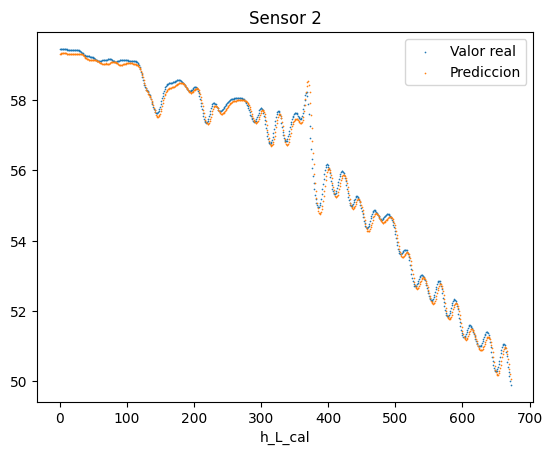

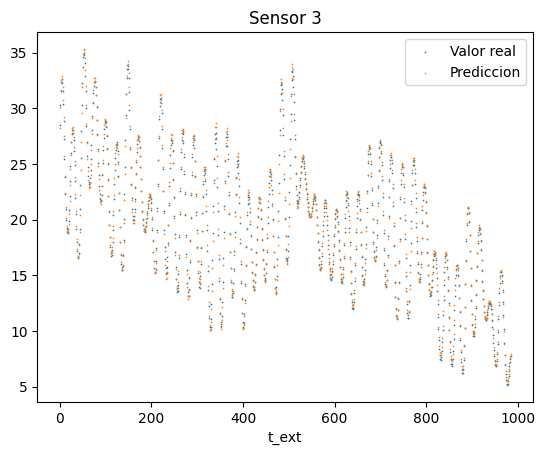

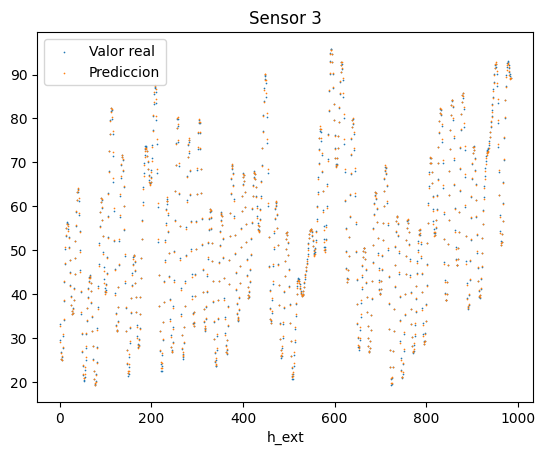

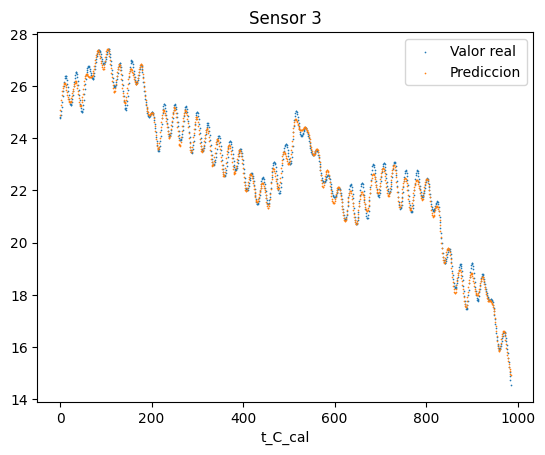

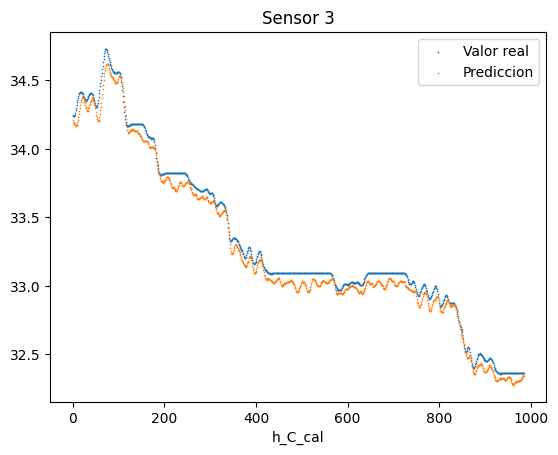

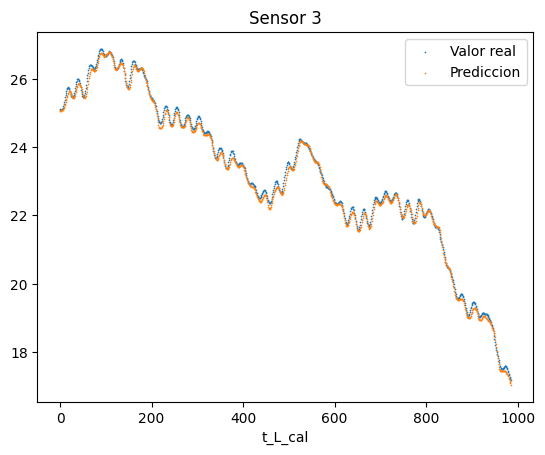

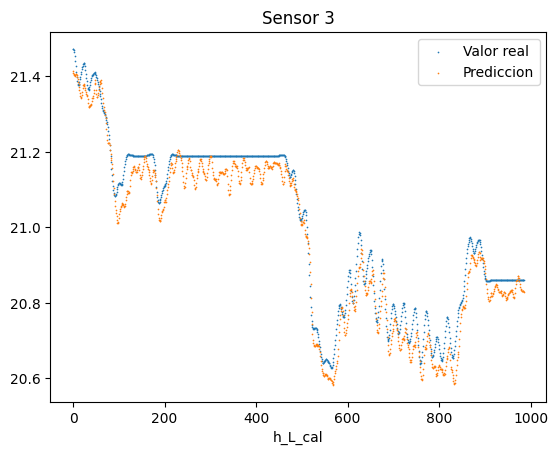

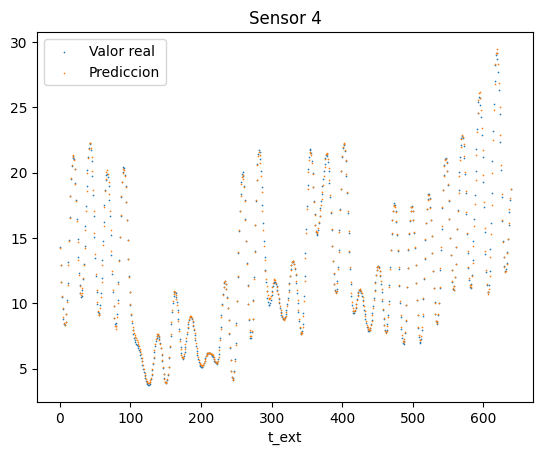

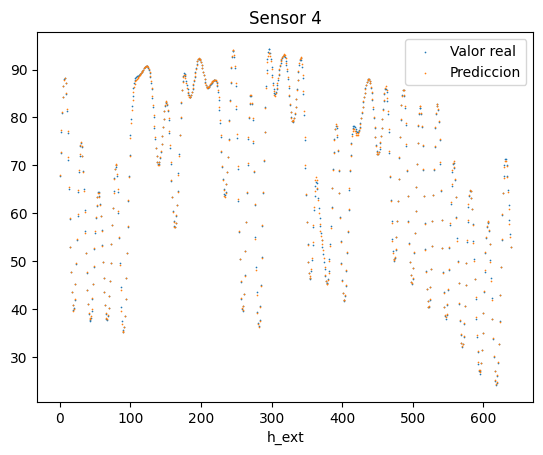

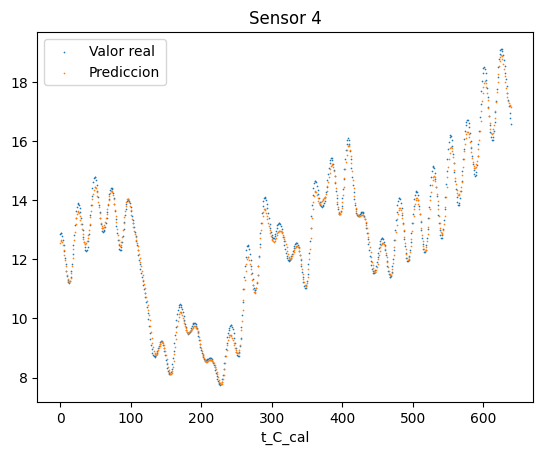

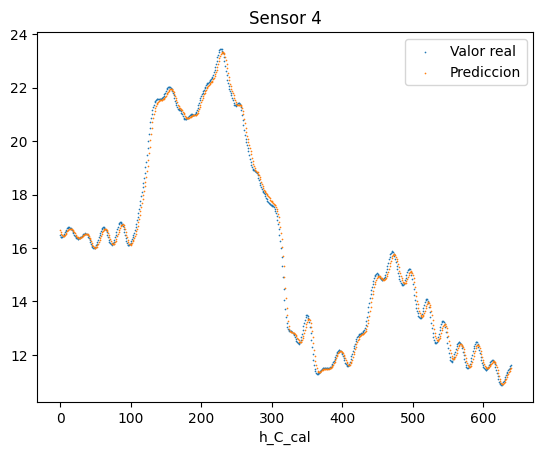

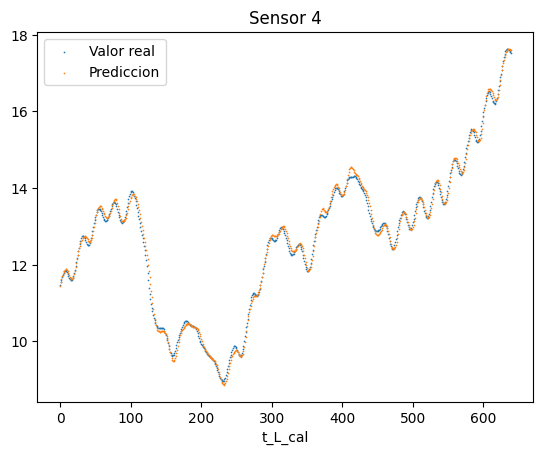

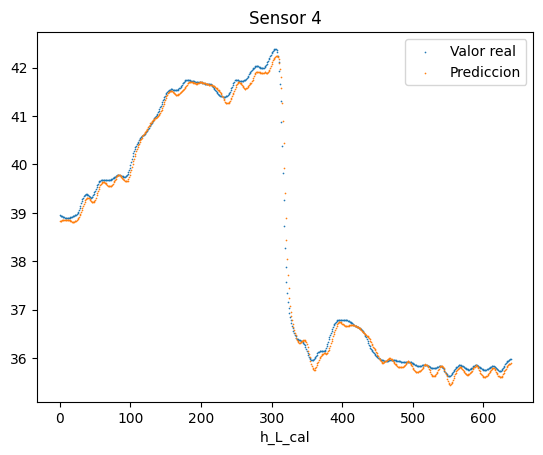

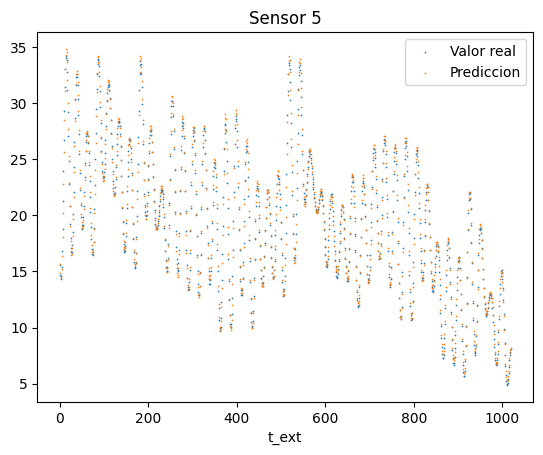

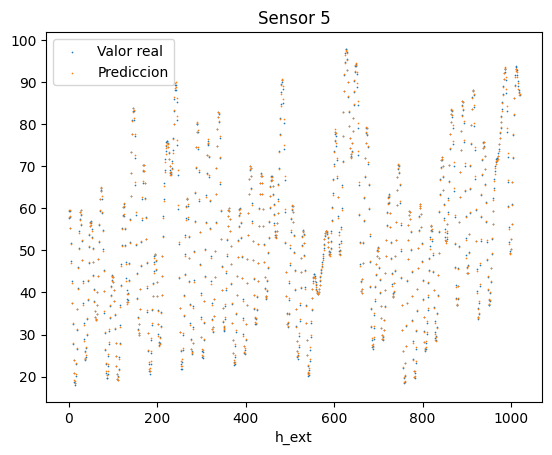

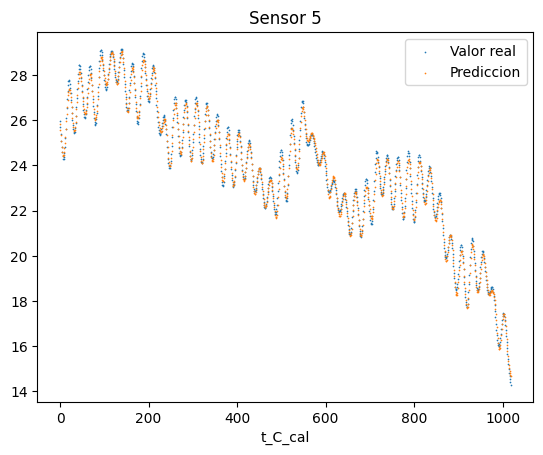

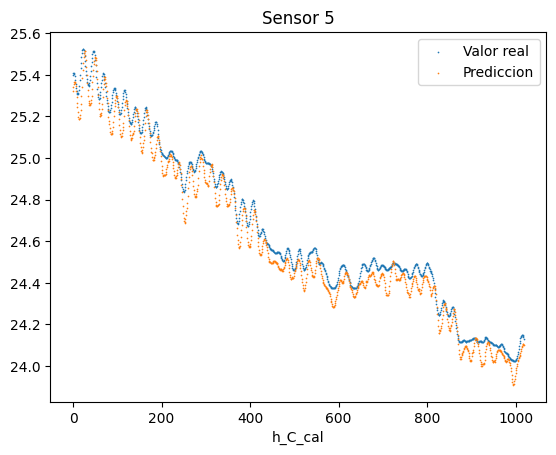

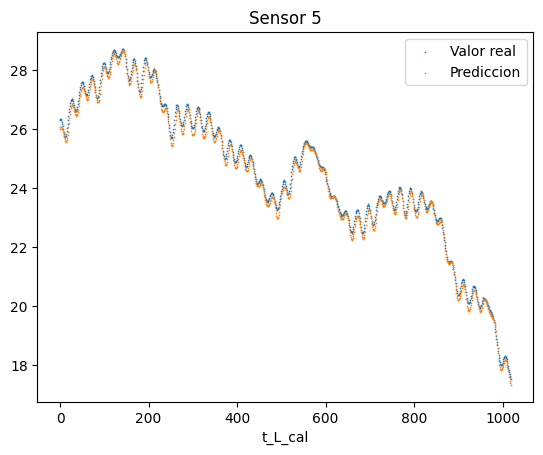

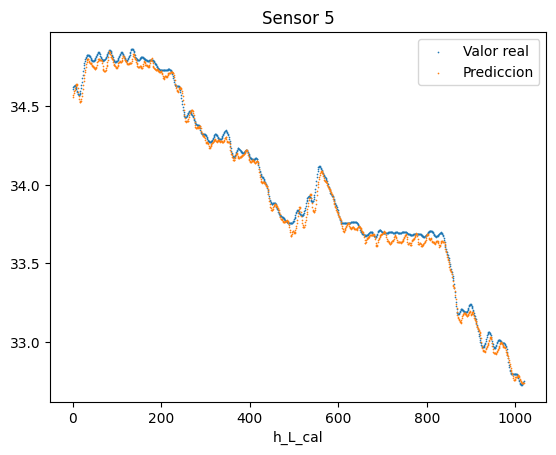

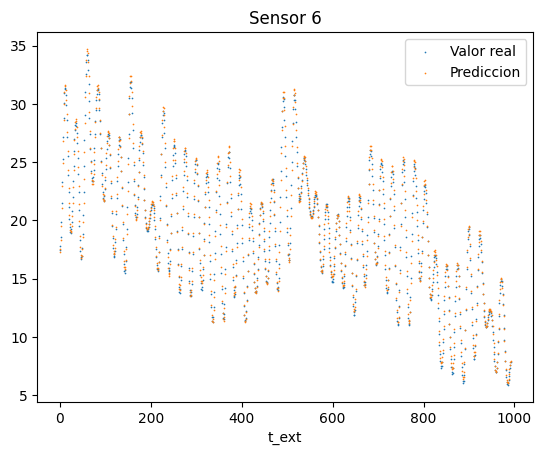

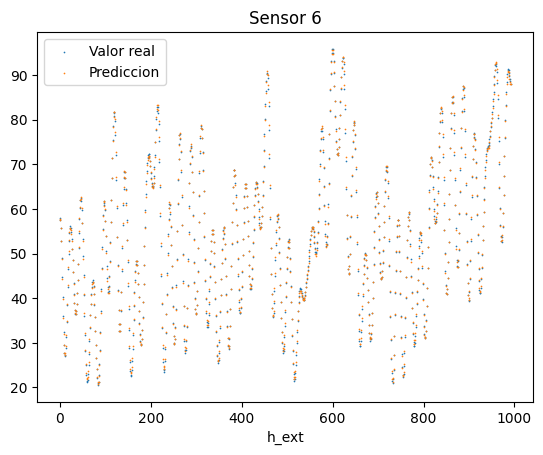

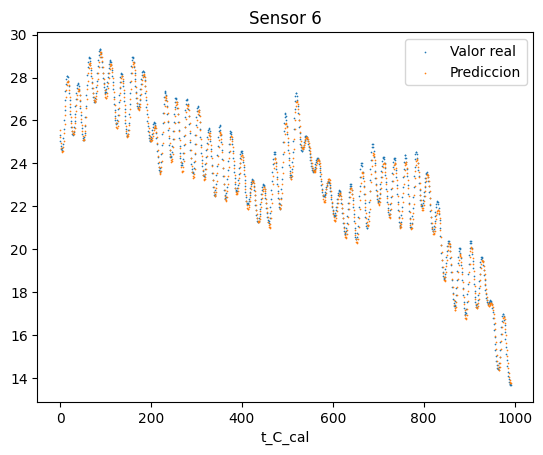

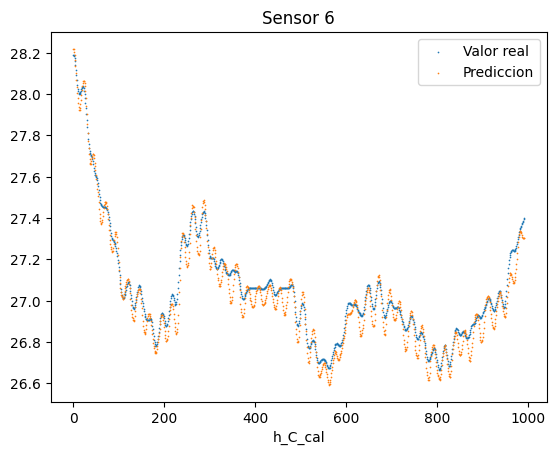

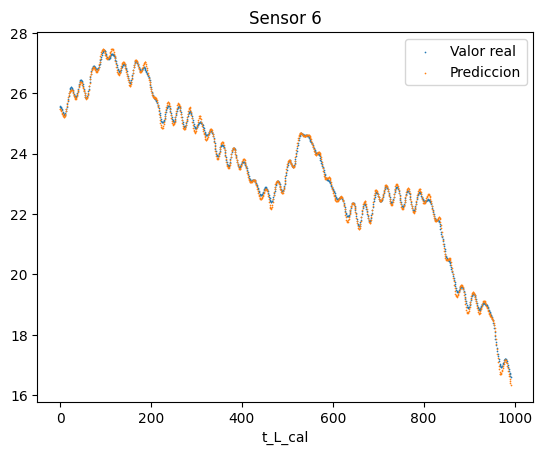

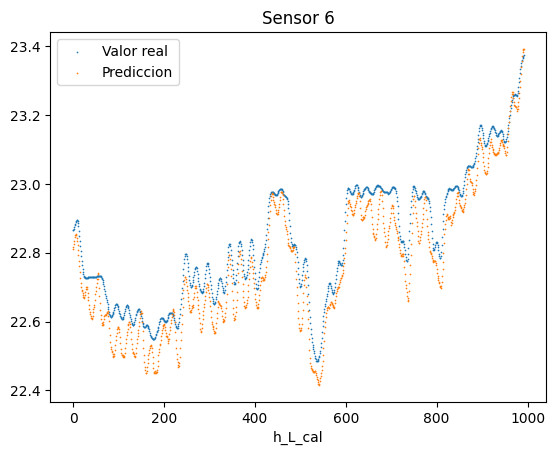

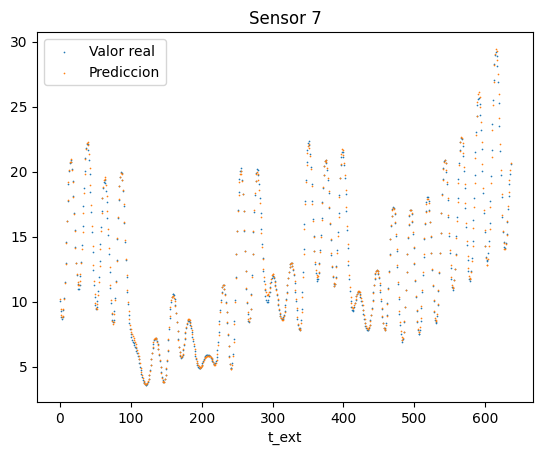

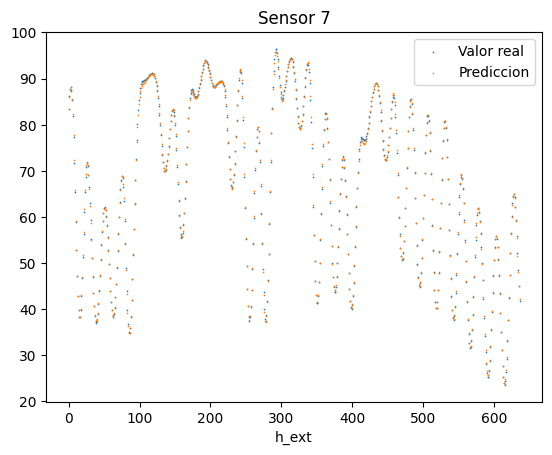

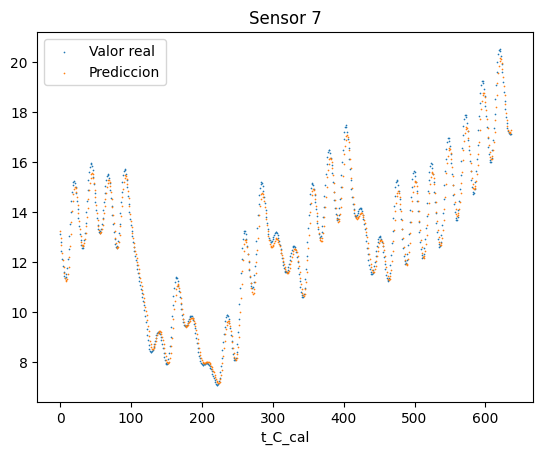

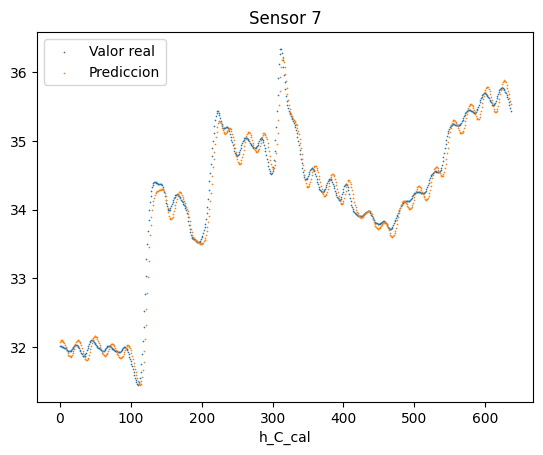

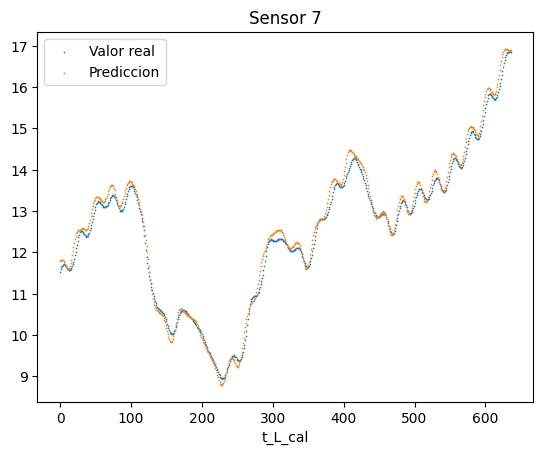

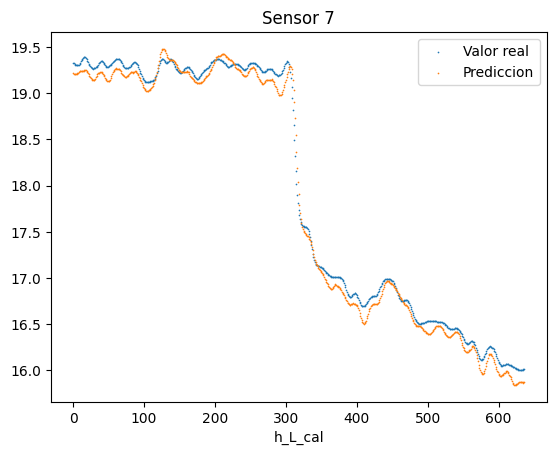

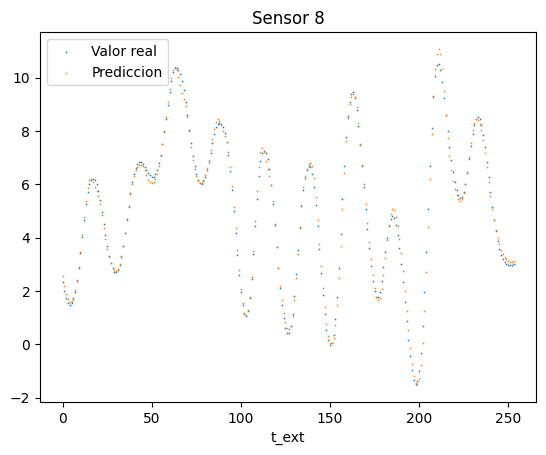

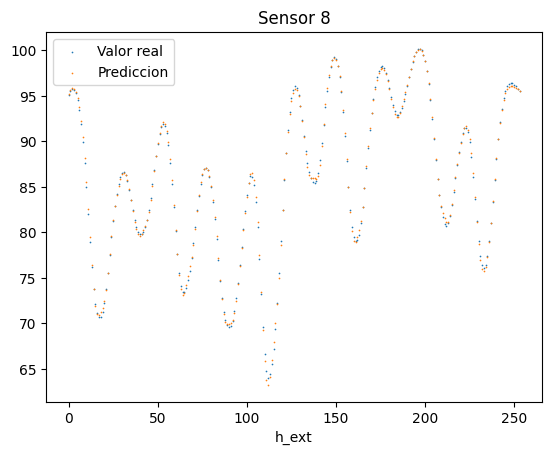

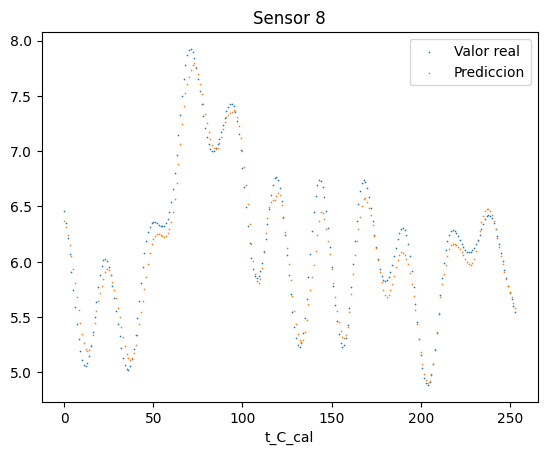

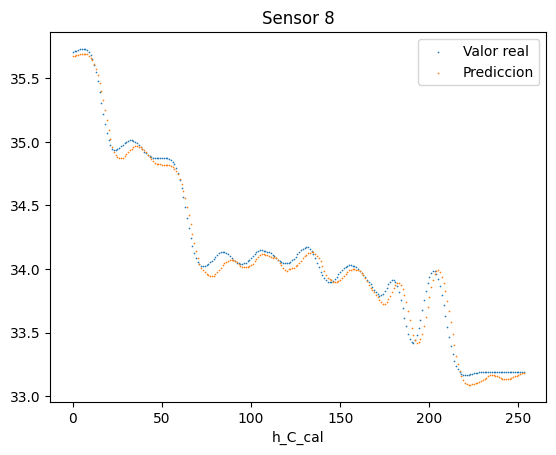

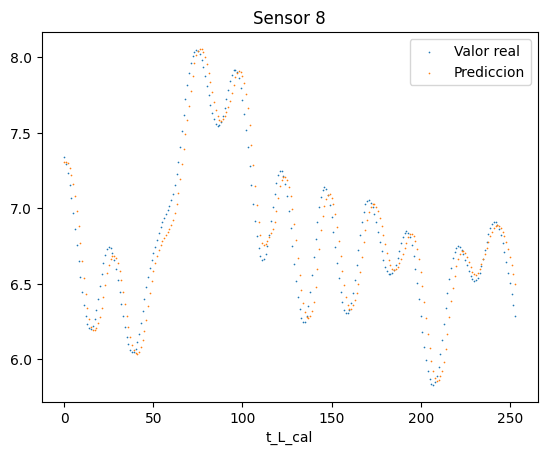

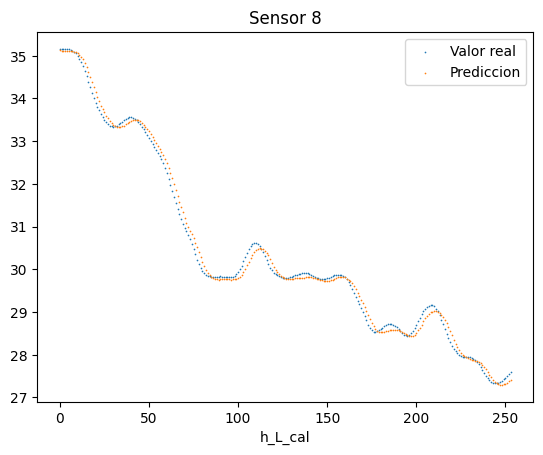

In [55]:
for sensor, (lim_inf, lim_sup) in enumerate(zip(data_limits, data_limits[1:]), 1):
    for col in INPUT_COLS:
        plt.figure(num="Sensor " + str(sensor))
        plt.title("Sensor " + str(sensor))
        plt.scatter(range(len(targets[col][lim_inf:lim_sup])), targets[col][lim_inf:lim_sup], linewidths=0.5, s=0.5)
        plt.scatter(range(len(predictions[col][lim_inf:lim_sup])), predictions[col][lim_inf:lim_sup], linewidths=0.5, s=0.5)
        plt.legend(["Valor real", "Prediccion"])
        plt.xlabel(col)
        plt.show()

In [56]:
for col in INPUT_COLS:
    print(col, max(abs(targets[col] - predictions[col])))

t_ext 1.4252011338012665
h_ext 1.2606144182488919
t_C_cal 1.094301780874403
h_C_cal 2.408725377392358
t_L_cal 0.4713091894884869
h_L_cal 1.198064001969172


In [57]:
# model.save("./ann_model", overwrite=True)